In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf

import librosa
# import librosa.display
# import IPython.display as ipd

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

#from tensorflow.keras.utils import to_categorical
#import keras

import logging, os

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import time
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import tree

In [3]:
os.chdir('/Users/stevenalexander/Documents/TUGAS AKHIR')

In [4]:
!pip install graphviz

# Demographic Information Text File

In [108]:
'''
Demographic Information
 The demographic info file has 6 columns:
  - Patient number
  - Age
  - Sex
  - Adult BMI (kg/m2)
  - Child Weight (kg)
  - Child Height (cm)
'''
demo = pd.read_csv('demographic_info.txt', sep=' ',names=['patient_id', 'age','sex','bmi','weight','height'])
print(demo.info())
demo.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  126 non-null    int64  
 1   age         125 non-null    float64
 2   sex         125 non-null    object 
 3   bmi         75 non-null     float64
 4   weight      44 non-null     float64
 5   height      42 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 6.0+ KB
None


patient_id    age sex   bmi  weight  height
0         101   3.00   F   NaN    19.0    99.0
1         102   0.75   F   NaN     9.8    73.0
2         103  70.00   F  33.0     NaN     NaN

In [109]:
'''
Elements contained in the filenames:

Patient number (101,102,...,226)
Recording index
Chest location (Trachea (Tc), {Anterior (A), Posterior (P), Lateral (L)}{left (l), right (r)})
Acquisition mode (sequential/single channel (sc), simultaneous/multichannel (mc))
Recording equipment (AKG C417L Microphone, 3M Littmann Classic II SE Stethoscope, 3M Litmmann 3200 Electronic Stethoscope, WelchAllyn Meditron Master Elite Electronic Stethoscope)
'''
file_info = pd.read_csv('filename_differences.txt', sep="_",names=['patient_id', 'rec_index','chest_loc','acq_mode','rec_equipment'])
file_info["patient_id"] = file_info["patient_id"].str.strip("'") .astype(int)
file_info["rec_equipment"] = file_info["rec_equipment"].str.strip("'")
print(file_info.info())
file_info.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patient_id     91 non-null     int64 
 1   rec_index      91 non-null     object
 2   chest_loc      91 non-null     object
 3   acq_mode       91 non-null     object
 4   rec_equipment  91 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.7+ KB
None


patient_id rec_index chest_loc acq_mode rec_equipment
0         101       1b1        Al       sc      AKGC417L
1         101       1b1        Pr       sc      AKGC417L
2         102       1b1        Ar       sc      AKGC417L

# Patient Diagnosis

In [110]:
'''
Patient Diagnosis
'''
diag = pd.read_csv("patient_diagnosis.csv", header = None).rename(columns = {0 : "patient", 1 : "diag_0"})
diag["diag_1"] = diag["diag_0"].replace({'Pneumonia': "LRTI", 'Bronchiolitis' : "LRTI"}) #'Bronchiectasis' : "LRTI"
diag["patient"] = diag["patient"].astype(int)
diag = diag.set_index("patient")
diag.head()

diag_0   diag_1
patient                  
101         URTI     URTI
102      Healthy  Healthy
103       Asthma   Asthma
104         COPD     COPD
105         URTI     URTI

In [111]:
diag["diag_0"].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: diag_0, dtype: int64

In [112]:
diag["diag_1"].value_counts()

COPD              64
Healthy           26
URTI              14
LRTI              14
Bronchiectasis     7
Asthma             1
Name: diag_1, dtype: int64

# Audio & Txt Files

In [113]:
os.chdir("audio_and_txt_files")
file_list = os.listdir()
wav_list = sorted([wav for wav in file_list if ".wav" in wav])
txt_list = sorted([txt for txt in file_list if ".txt" in txt])
print(f"Total audio file :{len(wav_list)}\nTotal txt file: {len(txt_list)}")

Total audio file :920
Total txt file: 920


In [114]:
df_txt = pd.DataFrame()
for txt_file in txt_list : 
  temp = pd.read_csv(txt_file,sep='\t',names=['start','end','crackles','weezels'])
  temp["file_name"] = txt_file.split(".")[0] 
  df_txt = pd.concat((df_txt, temp))

In [115]:
df_txt["patient_id"] = df_txt["file_name"].str.split("_").apply(lambda row : row[0]).astype(int)
print(df_txt.info())
df_txt.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start       6898 non-null   float64
 1   end         6898 non-null   float64
 2   crackles    6898 non-null   int64  
 3   weezels     6898 non-null   int64  
 4   file_name   6898 non-null   object 
 5   patient_id  6898 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 377.2+ KB
None


start    end  crackles  weezels               file_name  patient_id
0  0.036  0.579         0        0  101_1b1_Al_sc_Meditron         101
1  0.579  2.450         0        0  101_1b1_Al_sc_Meditron         101
2  2.450  3.893         0        0  101_1b1_Al_sc_Meditron         101

# Audio Array File

In [116]:
os.chdir('/Users/stevenalexander/Documents/TUGAS AKHIR')
audio_arr = np.load("audio_file.npy")
#audio_arr = audio_arr.tolist()
audio_arr[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [117]:
audio_arr.shape

(6898, 132300)

In [118]:
audio_arr[0].shape

(132300,)

# Final Table

In [119]:
'''
Extract Information
'''
df = df_txt.copy()

'''
Add Audio Array Files
'''
df["audio_arr"] = pd.Series(list(audio_arr))

'''
Add file name information
'''
#df = pd.merge(df, file_info, how = 'left', on = "patient_id")


'''
Add Demographic Features
'''
df = pd.merge(df, demo, how = 'left', on = "patient_id")

'''
Apply Patient diagnosis
'''
df["diag"] = df["patient_id"].replace(diag["diag_1"].to_dict())

'''
Drop Duplicates
'''
#df = df.drop_duplicates()

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 6897
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start       6898 non-null   float64
 1   end         6898 non-null   float64
 2   crackles    6898 non-null   int64  
 3   weezels     6898 non-null   int64  
 4   file_name   6898 non-null   object 
 5   patient_id  6898 non-null   int64  
 6   audio_arr   6898 non-null   object 
 7   age         6837 non-null   float64
 8   sex         6837 non-null   object 
 9   bmi         6004 non-null   float64
 10  weight      749 non-null    float64
 11  height      726 non-null    float64
 12  diag        6898 non-null   object 
dtypes: float64(6), int64(3), object(4)
memory usage: 754.5+ KB
None


start    end  crackles  weezels               file_name  patient_id  \
0  0.036  0.579         0        0  101_1b1_Al_sc_Meditron         101   
1  0.579  2.450         0        0  101_1b1_Al_sc_Meditron         101   
2  2.450  3.893         0        0  101_1b1_Al_sc_Meditron         101   
3  3.893  5.793         0        0  101_1b1_Al_sc_Meditron         101   
4  5.793  7.521         0        0  101_1b1_Al_sc_Meditron         101   

                                           audio_arr  age sex  bmi  weight  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  NaN    19.0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  NaN    19.0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  NaN    19.0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  NaN    19.0   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  NaN    19.0   

   height  diag  
0    99.0  URTI  
1    99.0  URTI  
2    99.0  URTI  
3    99.0  URTI  
4    99.0  URTI

In [120]:
df["diag"].value_counts() / len(df) * 100

COPD              83.299507
LRTI               6.915048
Healthy            4.668020
URTI               3.522760
Bronchiectasis     1.507683
Asthma             0.086982
Name: diag, dtype: float64

In [121]:
df.isna().sum() / len(df) * 100

start          0.000000
end            0.000000
crackles       0.000000
weezels        0.000000
file_name      0.000000
patient_id     0.000000
audio_arr      0.000000
age            0.884314
sex            0.884314
bmi           12.960278
weight        89.141780
height        89.475210
diag           0.000000
dtype: float64

# Data Preparation for Modeling  

From the present columns, there are several possible columns that can be used as feature for modeling. 
- start
- end
- crackles
- weezels
- chest loc
- acq_mode
- rec_equipment
- sex
- age
- bmi
- weight
- height

Target variable : 
- diag

## Mapping Target Variable

In [122]:
'''
Map Target Variables to Binary Class
'''
print(f'Initial Target Variables:\n{df["diag"].value_counts()}\n')
df["diag1"] = df["diag"].apply(lambda row : "non-COPD" if row != "COPD" else row)
print(f'Final Target Variables:\n{df["diag1"].value_counts()}\n')

Initial Target Variables:
COPD              5746
LRTI               477
Healthy            322
URTI               243
Bronchiectasis     104
Asthma               6
Name: diag, dtype: int64

Final Target Variables:
COPD        5746
non-COPD    1152
Name: diag1, dtype: int64



In [123]:
'''
Label Encoding
'''
df["diag1"] = df["diag1"].apply(lambda row : 0 if row != "COPD" else 1)
print(f'Final Target Variables:\n{df["diag1"].value_counts()}\n')

Final Target Variables:
1    5746
0    1152
Name: diag1, dtype: int64



# Feature Engineering

In [223]:
'''
Initial Regression Columns (<= 10%  nan data)
'''
nan_threshold = 10 #10% of nan data from all data
df_nan_col = df.isna().sum() / len(df) * 100
init_col = [col for col in df.columns if df_nan_col.loc[col] <= nan_threshold]
print(f'Initial Columns:\n {init_col}')
df0 = df[init_col]
df0.head(3)

Initial Columns:
 ['start', 'end', 'crackles', 'weezels', 'file_name', 'patient_id', 'audio_arr', 'age', 'sex', 'diag', 'diag1']


start    end  crackles  weezels               file_name  patient_id  \
0  0.036  0.579         0        0  101_1b1_Al_sc_Meditron         101   
1  0.579  2.450         0        0  101_1b1_Al_sc_Meditron         101   
2  2.450  3.893         0        0  101_1b1_Al_sc_Meditron         101   

                                           audio_arr  age sex  diag  diag1  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI      0  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI      0  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI      0

In [224]:
'''
Descriptive Statistic from audio array
- Mean
- Median
- Max
- Min
- std
'''
def generate_desc_statistic_features(temp_df, row_name): 
    temp_df['mean'] = temp_df[row_name].apply(lambda row : np.mean(row))
    temp_df['median'] = temp_df[row_name].apply(lambda row : np.median(row))
    temp_df['max'] = temp_df[row_name].apply(lambda row : np.max(row))
    temp_df['min'] = temp_df[row_name].apply(lambda row : np.min(row))
    temp_df['std'] = temp_df[row_name].apply(lambda row : np.std(row))
    return(temp_df.drop(columns = [row_name]))

def generate_desc_statistic_features_remove_zero_padding(temp_df, row_name): 
    temp_df['mean_non_pad'] = temp_df[row_name].apply(lambda row : np.mean(np.trim_zeros(row)))
    temp_df['median_non_pad'] = temp_df[row_name].apply(lambda row : np.median(np.trim_zeros(row)))
    temp_df['max_non_pad'] = temp_df[row_name].apply(lambda row : np.max(np.trim_zeros(row)))
    temp_df['min_non_pad'] = temp_df[row_name].apply(lambda row : np.min(np.trim_zeros(row)))
    temp_df['std_non_pad'] = temp_df[row_name].apply(lambda row : np.std(np.trim_zeros(row)))
    return(temp_df.drop(columns = [row_name]))
    
'''
Zero and Non-Zero Value
'''
def generate_zero_non_zero_features(temp_df, row_name): 
    #print('yes')
    temp_df["non_zero"] = temp_df[row_name].apply(lambda row : np.count_nonzero(row))
    temp_df["zero"] = temp_df.apply(lambda row : len(row) - row["non_zero"], axis = 1)
    return(temp_df.drop(columns = [row_name]))
    
'''
duration
'''
def generate_duration_data(temp_df, row_name): 
    #print('yes')
    temp_df["duration"] = temp_df.apply(lambda row : row['end'] - row['start'], axis = 1)
    #print(temp_df.drop(columns = [row_name]))
    return(temp_df.drop(columns = [row_name]))
    
'''
APPLY Feature Generation Functions
'''
def generate_features(temp_df, row_name): 
    df = temp_df.copy()
    
    features_col_outputs = [
                            df,
                            generate_desc_statistic_features(df[[row_name]], row_name), 
                            generate_desc_statistic_features_remove_zero_padding(df[[row_name]], row_name), 
                            generate_zero_non_zero_features(df[[row_name]], row_name), 
                            generate_duration_data(df[[row_name, 'end', 'start']], row_name)
                           ]

    outputs = pd.concat(features_col_outputs, axis = 1)
    return(outputs)

In [133]:
df0.to_csv('\generated_regression_features\init_reg_features.csv')

In [225]:
'''
Generate Features
'''
pd.set_option('mode.chained_assignment', None)
start = time.time()
test  = df0.head(10)
test = generate_features(test, 'audio_arr')
print(time.time()- start)

9.108336210250854


In [144]:
test#.isna().sum()

start    end  crackles  weezels               file_name  patient_id  \
0  0.036  0.579         0        0  101_1b1_Al_sc_Meditron         101   
1  0.036  0.579         0        0  101_1b1_Al_sc_Meditron         101   
2  0.579  2.450         0        0  101_1b1_Al_sc_Meditron         101   
3  0.579  2.450         0        0  101_1b1_Al_sc_Meditron         101   
4  2.450  3.893         0        0  101_1b1_Al_sc_Meditron         101   
5  2.450  3.893         0        0  101_1b1_Al_sc_Meditron         101   
6  3.893  5.793         0        0  101_1b1_Al_sc_Meditron         101   
7  3.893  5.793         0        0  101_1b1_Al_sc_Meditron         101   
8  5.793  7.521         0        0  101_1b1_Al_sc_Meditron         101   
9  5.793  7.521         0        0  101_1b1_Al_sc_Meditron         101   

                                           audio_arr  age sex  diag  ...  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   
9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3.0   F  URTI  ...   

   mean_non_pad  median_non_pad  max_non_pad  min_non_pad  std_non_pad  \
0     -0.003042       -0.006038     0.357368    -0.173838     0.079768   
1     -0.003042       -0.006038     0.357368    -0.173838     0.079768   
2     -0.000864       -0.003920     0.394690    -0.200152     0.073532   
3     -0.000864       -0.003920     0.394690    -0.200152     0.073532   
4      0.001312       -0.002659     0.411698    -0.161825     0.070128   
5      0.001312       -0.002659     0.411698    -0.161825     0.070128   
6     -0.000797       -0.003198     0.414743    -0.130865     0.064324   
7     -0.000797       -0.003198     0.414743    -0.130865     0.064324   
8     -0.000109       -0.008479     0.293682    -0.150968     0.057634   
9     -0.000109       -0.008479     0.293682    -0.150968     0.057634   

   non_zero   zero    end  start  duration  
0     11973 -11971  0.579  0.036     0.543  
1     11973 -11971  0.579  0.036     0.543  
2     41256 -41254  2.450  0.579     1.871  
3     41256 -41254  2.450  0.579     1.871  
4     31818 -31816  3.893  2.450     1.443  
5     31818 -31816  3.893  2.450     1.443  
6     41895 -41893  5.793  3.893     1.900  
7     41895 -41893  5.793  3.893     1.900  
8     38103 -38101  7.521  5.793     1.728  
9     38103 -38101  7.521  5.793     1.728  

[10 rows x 26 columns]

In [115]:
test.drop(columns = ['audio_arr'])#to_csv(f'generated_regression_features/version 1/reg_feature_ver1_{1}.csv')

start    end  crackles  weezels               file_name  patient_id  age  \
0  0.036  0.579         0        0  101_1b1_Al_sc_Meditron         101  3.0   
1  0.036  0.579         0        0  101_1b1_Al_sc_Meditron         101  3.0   
2  0.579  2.450         0        0  101_1b1_Al_sc_Meditron         101  3.0   
3  0.579  2.450         0        0  101_1b1_Al_sc_Meditron         101  3.0   
4  2.450  3.893         0        0  101_1b1_Al_sc_Meditron         101  3.0   
5  2.450  3.893         0        0  101_1b1_Al_sc_Meditron         101  3.0   
6  3.893  5.793         0        0  101_1b1_Al_sc_Meditron         101  3.0   
7  3.893  5.793         0        0  101_1b1_Al_sc_Meditron         101  3.0   
8  5.793  7.521         0        0  101_1b1_Al_sc_Meditron         101  3.0   
9  5.793  7.521         0        0  101_1b1_Al_sc_Meditron         101  3.0   

  sex  diag  diag1      mean  median       max       min       std  \
0   F  URTI      0 -0.000275     0.0  0.357368 -0.173838  0.024012   
1   F  URTI      0 -0.000275     0.0  0.357368 -0.173838  0.024012   
2   F  URTI      0 -0.000269     0.0  0.394690 -0.200152  0.041064   
3   F  URTI      0 -0.000269     0.0  0.394690 -0.200152  0.041064   
4   F  URTI      0  0.000316     0.0  0.411698 -0.161825  0.034396   
5   F  URTI      0  0.000316     0.0  0.411698 -0.161825  0.034396   
6   F  URTI      0 -0.000252     0.0  0.414743 -0.130865  0.036199   
7   F  URTI      0 -0.000252     0.0  0.414743 -0.130865  0.036199   
8   F  URTI      0 -0.000031     0.0  0.293682 -0.150968  0.030930   
9   F  URTI      0 -0.000031     0.0  0.293682 -0.150968  0.030930   

   mean_non_pad  median_non_pad  max_non_pad  min_non_pad  std_non_pad  
0     -0.003042       -0.006038     0.357368    -0.173838     0.079768  
1     -0.003042       -0.006038     0.357368    -0.173838     0.079768  
2     -0.000864       -0.003920     0.394690    -0.200152     0.073532  
3     -0.000864       -0.003920     0.394690    -0.200152     0.073532  
4      0.001312       -0.002659     0.411698    -0.161825     0.070128  
5      0.001312       -0.002659     0.411698    -0.161825     0.070128  
6     -0.000797       -0.003198     0.414743    -0.130865     0.064324  
7     -0.000797       -0.003198     0.414743    -0.130865     0.064324  
8     -0.000109       -0.008479     0.293682    -0.150968     0.057634  
9     -0.000109       -0.008479     0.293682    -0.150968     0.057634

In [116]:
df0['index'] = df0.index
df0.sample(5)

start     end  crackles  weezels               file_name  patient_id  \
5513  15.407  16.736         0        0  188_1b1_Al_sc_Meditron         188   
4953   0.042   1.280         0        0  178_1b2_Al_mc_AKGC417L         178   
1051   0.050   2.404         0        0  127_1b1_Ar_sc_Meditron         127   
7474  12.559  13.969         0        0  216_1b1_Al_sc_Meditron         216   
3004   6.396   8.938         1        0  154_2b4_Pr_mc_AKGC417L         154   

                                              audio_arr   age sex     diag  \
5513  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   3.0   M     URTI   
4953  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  58.0   M     COPD   
1051  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   2.0   M  Healthy   
7474  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   1.0   M     LRTI   
3004  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  65.0   M     COPD   

      ...  median       max       min       std  mean_non_pad  median_non_pad  \
5513  ...     0.0  0.267623 -0.184955  0.030619     -0.000546       -0.001988   
4953  ...     0.0  0.357368 -0.173838  0.024012     -0.003042       -0.006038   
1051  ...     0.0  0.357368 -0.173838  0.024012     -0.003042       -0.006038   
7474  ...     0.0  0.330056 -0.167619  0.029009     -0.000070       -0.004662   
3004  ...     0.0  0.411698 -0.161825  0.034396      0.001312       -0.002659   

      max_non_pad  min_non_pad  std_non_pad  index  
5513     0.267623    -0.184955     0.062134   5513  
4953     0.357368    -0.173838     0.079768   4953  
1051     0.357368    -0.173838     0.079768   1051  
7474     0.330056    -0.167619     0.051742   7474  
3004     0.411698    -0.161825     0.070128   3004  

[5 rows x 22 columns]

In [145]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   start           10 non-null     float64
 1   end             10 non-null     float64
 2   crackles        10 non-null     int64  
 3   weezels         10 non-null     int64  
 4   file_name       10 non-null     object 
 5   patient_id      10 non-null     int64  
 6   audio_arr       10 non-null     object 
 7   age             10 non-null     float64
 8   sex             10 non-null     object 
 9   diag            10 non-null     object 
 10  diag1           10 non-null     int64  
 11  mean            10 non-null     float32
 12  median          10 non-null     float32
 13  max             10 non-null     float32
 14  min             10 non-null     float32
 15  std             10 non-null     float32
 16  mean_non_pad    10 non-null     float32
 17  median_non_pad  10 non-null     float3

In [226]:
'''
Export per 1000 rows 
'''
export_data_range = np.concatenate((np.arange(0, len(df0)+1, 1000) , [len(df0)+1]))
for i in range(len(export_data_range)-1) : 
    start_idx = export_data_range[i] 
    end_idx = export_data_range[i+1]
    output = generate_features(df0.iloc[start_idx : end_idx], 'audio_arr').drop(columns = ['audio_arr'])
    output.to_csv(f'generated_regression_features/version 2/reg_feature_ver1_{i+1}.csv')
    del output

In [227]:
print('test')

test


# Read CSV Version 1

In [183]:
reg_df = pd.DataFrame()
for i in range(7) :
    temp = pd.read_csv(f'generated_regression_features/version 2/reg_feature_ver1_{i+1}.csv')
    temp.index = temp['Unnamed: 0']
    temp = temp.drop(columns = ['Unnamed: 0'])
    reg_df = pd.concat((reg_df, temp))
reg_df.index.name = None
reg_df.drop(columns = ['file_name', 'diag'], inplace = True)
reg_df['zero'] = 132300 - reg_df['non_zero']
#reg_df[['zero', 'non_zero']]
#reg_df = reg_df.drop_duplicates()

In [184]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 6897
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   start           6898 non-null   float64
 1   end             6898 non-null   float64
 2   crackles        6898 non-null   int64  
 3   weezels         6898 non-null   int64  
 4   patient_id      6898 non-null   int64  
 5   age             6837 non-null   float64
 6   sex             6837 non-null   object 
 7   diag1           6898 non-null   int64  
 8   mean            6898 non-null   float64
 9   median          6898 non-null   float64
 10  max             6898 non-null   float64
 11  min             6898 non-null   float64
 12  std             6898 non-null   float64
 13  mean_non_pad    6898 non-null   float64
 14  median_non_pad  6898 non-null   float64
 15  max_non_pad     6898 non-null   float64
 16  min_non_pad     6898 non-null   float64
 17  std_non_pad     6898 non-null   f

In [185]:
reg_df.columns

Index(['start', 'end', 'crackles', 'weezels', 'patient_id', 'age', 'sex',
       'diag1', 'mean', 'median', 'max', 'min', 'std', 'mean_non_pad',
       'median_non_pad', 'max_non_pad', 'min_non_pad', 'std_non_pad',
       'non_zero', 'zero', 'end.1', 'start.1', 'duration'],
      dtype='object')

In [186]:
reg_df['diag1'].value_counts() / len(reg_df)

1    0.832995
0    0.167005
Name: diag1, dtype: float64

In [187]:
reg_df

start     end  crackles  weezels  patient_id  age sex  diag1      mean  \
0      0.036   0.579         0        0         101  3.0   F      0 -0.000275   
1      0.579   2.450         0        0         101  3.0   F      0 -0.000269   
2      2.450   3.893         0        0         101  3.0   F      0  0.000316   
3      3.893   5.793         0        0         101  3.0   F      0 -0.000252   
4      5.793   7.521         0        0         101  3.0   F      0 -0.000031   
...      ...     ...       ...      ...         ...  ...  ..    ...       ...   
6893  11.721  13.693         1        0         226  4.0   M      0 -0.000132   
6894  13.693  15.536         0        0         226  4.0   M      0 -0.000022   
6895  15.536  17.493         0        0         226  4.0   M      0  0.000210   
6896  17.493  19.436         1        0         226  4.0   M      0 -0.000036   
6897  19.436  19.979         0        0         226  4.0   M      0  0.000015   

      median  ...  mean_non_pad  median_non_pad  max_non_pad  min_non_pad  \
0        0.0  ...     -0.003042       -0.006038     0.357368    -0.173838   
1        0.0  ...     -0.000864       -0.003920     0.394690    -0.200152   
2        0.0  ...      0.001312       -0.002659     0.411698    -0.161825   
3        0.0  ...     -0.000797       -0.003198     0.414743    -0.130865   
4        0.0  ...     -0.000109       -0.008479     0.293682    -0.150968   
...      ...  ...           ...             ...          ...          ...   
6893     0.0  ...     -0.000424       -0.001773     0.323450    -0.165248   
6894     0.0  ...     -0.000070       -0.004662     0.330056    -0.167619   
6895     0.0  ...      0.000749       -0.003692     0.225929    -0.186095   
6896     0.0  ...     -0.000108       -0.004664     0.295298    -0.165961   
6897     0.0  ...      0.000049        0.002013     0.263377    -0.143301   

      std_non_pad  non_zero    zero   end.1  start.1  duration  
0        0.079768     11973  120327   0.579    0.036     0.543  
1        0.073532     41256   91044   2.450    0.579     1.871  
2        0.070128     31818  100482   3.893    2.450     1.443  
3        0.064324     41895   90405   5.793    3.893     1.900  
4        0.057634     38103   94197   7.521    5.793     1.728  
...           ...       ...     ...     ...      ...       ...  
6893     0.058012     41256   91044  13.693   11.721     1.972  
6894     0.051742     41586   90714  15.536   13.693     1.843  
6895     0.048571     37155   95145  17.493   15.536     1.957  
6896     0.058878     43791   88509  19.436   17.493     1.943  
6897     0.051176     39690   92610  19.979   19.436     0.543  

[6898 rows x 23 columns]

# Feature Labeling

In [188]:
reg_df.select_dtypes(object).head()

sex
0   F
1   F
2   F
3   F
4   F

In [189]:
'''
Label Encoding
'''
reg_df['sex'] = reg_df['sex'].replace({'F' : 0, 'M' : 1}) 

In [190]:
reg_df.select_dtypes(object).head()

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

# Feature Selection

In [191]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 6897
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   start           6898 non-null   float64
 1   end             6898 non-null   float64
 2   crackles        6898 non-null   int64  
 3   weezels         6898 non-null   int64  
 4   patient_id      6898 non-null   int64  
 5   age             6837 non-null   float64
 6   sex             6837 non-null   float64
 7   diag1           6898 non-null   int64  
 8   mean            6898 non-null   float64
 9   median          6898 non-null   float64
 10  max             6898 non-null   float64
 11  min             6898 non-null   float64
 12  std             6898 non-null   float64
 13  mean_non_pad    6898 non-null   float64
 14  median_non_pad  6898 non-null   float64
 15  max_non_pad     6898 non-null   float64
 16  min_non_pad     6898 non-null   float64
 17  std_non_pad     6898 non-null   f

## Remove Unnecessary Column

In [192]:
reg_df.drop(columns = ['start.1','end.1', 'patient_id', 'duration', 'age'], inplace = True)

## Nan Values

In [193]:
reg_df.isna().sum() / len(reg_df)

start             0.000000
end               0.000000
crackles          0.000000
weezels           0.000000
sex               0.008843
diag1             0.000000
mean              0.000000
median            0.000000
max               0.000000
min               0.000000
std               0.000000
mean_non_pad      0.000000
median_non_pad    0.000000
max_non_pad       0.000000
min_non_pad       0.000000
std_non_pad       0.000000
non_zero          0.000000
zero              0.000000
dtype: float64

In [195]:
'''
Fillnan values 
'''
# reg_df['age'] = reg_df['age'].fillna(reg_df['age'].mean())
reg_df['sex'] = reg_df['sex'].fillna(reg_df['sex'].value_counts().iloc[0])

## Remove 0 STD

In [196]:
reg_df.describe().T

count          mean          std           min           25%  \
start           6898.0     10.680312     9.871169      0.000000      4.042000   
end             6898.0     13.380821    10.032744      0.250000      6.820250   
crackles        6898.0      0.343578     0.474937      0.000000      0.000000   
weezels         6898.0      0.201798     0.401371      0.000000      0.000000   
sex             6898.0     40.311685   419.860672      0.000000      0.000000   
diag1           6898.0      0.832995     0.373007      0.000000      1.000000   
mean            6898.0     -0.000051     0.000224     -0.000428     -0.000269   
median          6898.0      0.000000     0.000000      0.000000      0.000000   
max             6898.0      0.346738     0.069859      0.052906      0.302336   
min             6898.0     -0.159840     0.024304     -0.200152     -0.173838   
std             6898.0      0.031813     0.005630      0.010178      0.029009   
mean_non_pad    6898.0     -0.000404     0.001266     -0.003042     -0.000864   
median_non_pad  6898.0     -0.004164     0.002253     -0.008479     -0.006038   
max_non_pad     6898.0      0.346738     0.069859      0.052906      0.302336   
min_non_pad     6898.0     -0.159840     0.024304     -0.200152     -0.173838   
std_non_pad     6898.0      0.063573     0.010750      0.017591      0.057634   
non_zero        6898.0  35271.581763  9852.494334  11973.000000  31818.000000   
zero            6898.0  97028.418237  9852.494334  84716.000000  91044.000000   

                         50%            75%            max  
start               9.336000      14.826250      84.365000  
end                12.125000      17.671000      86.200000  
crackles            0.000000       1.000000       1.000000  
weezels             0.000000       0.000000       1.000000  
sex                 1.000000       1.000000    4485.000000  
diag1               1.000000       1.000000       1.000000  
mean               -0.000036       0.000207       0.000562  
median              0.000000       0.000000       0.000000  
max                 0.357368       0.411698       0.414743  
min                -0.161825      -0.131835      -0.046447  
std                 0.030930       0.036199       0.041064  
mean_non_pad       -0.000109       0.000705       0.001634  
median_non_pad     -0.003920      -0.002659       0.004642  
max_non_pad         0.357368       0.411698       0.414743  
min_non_pad        -0.161825      -0.131835      -0.046447  
std_non_pad         0.064324       0.073532       0.079768  
non_zero        38763.000000   41256.000000   47584.000000  
zero            93537.000000  100482.000000  120327.000000

In [197]:
'''
Remove Median Columns
'''
zero_std = reg_df.drop(columns = ['diag1']).describe().T
zero_std[zero_std['std'] == 0]

count  mean  std  min  25%  50%  75%  max
median  6898.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [198]:
zero_std['std'].round(5)

start                9.87117
end                 10.03274
crackles             0.47494
weezels              0.40137
sex                419.86067
mean                 0.00022
median               0.00000
max                  0.06986
min                  0.02430
std                  0.00563
mean_non_pad         0.00127
median_non_pad       0.00225
max_non_pad          0.06986
min_non_pad          0.02430
std_non_pad          0.01075
non_zero          9852.49433
zero              9852.49433
Name: std, dtype: float64

In [199]:
'''
Remove Median Feature
'''
reg_df.drop(columns = ['median'], inplace = True)

## Correlation Analysis with dependant variable

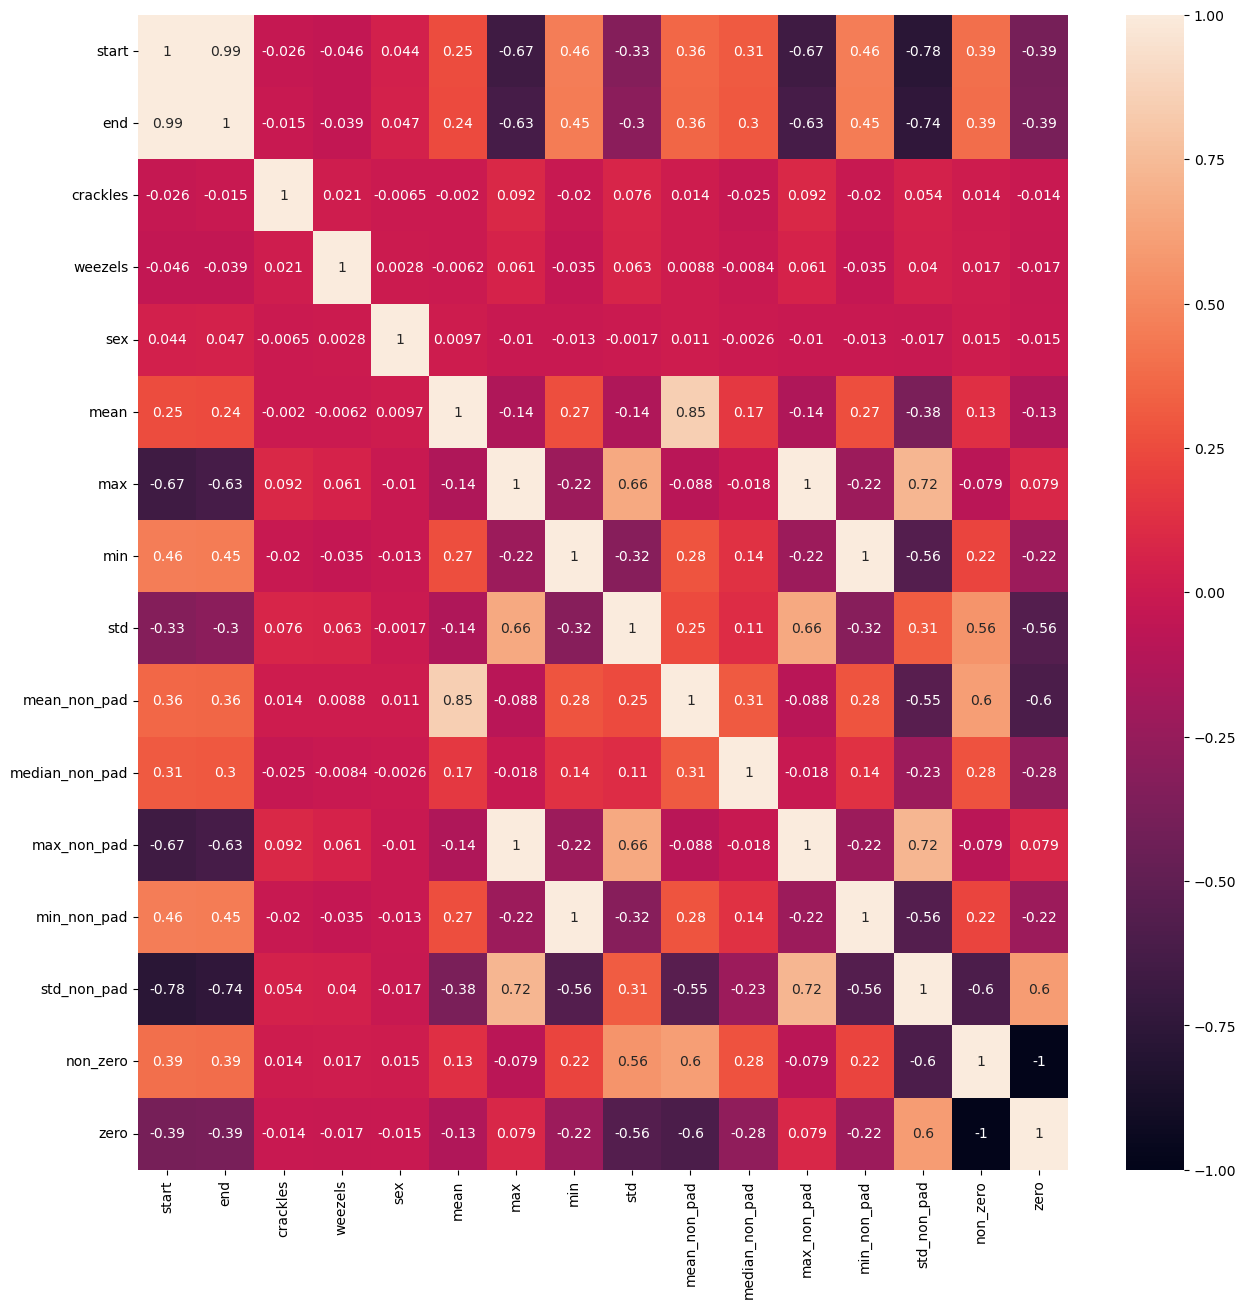

In [200]:
plt.figure(figsize = (15,15))
sns.heatmap(reg_df.drop(columns = ['diag1']).corr(), annot = True)
plt.show()

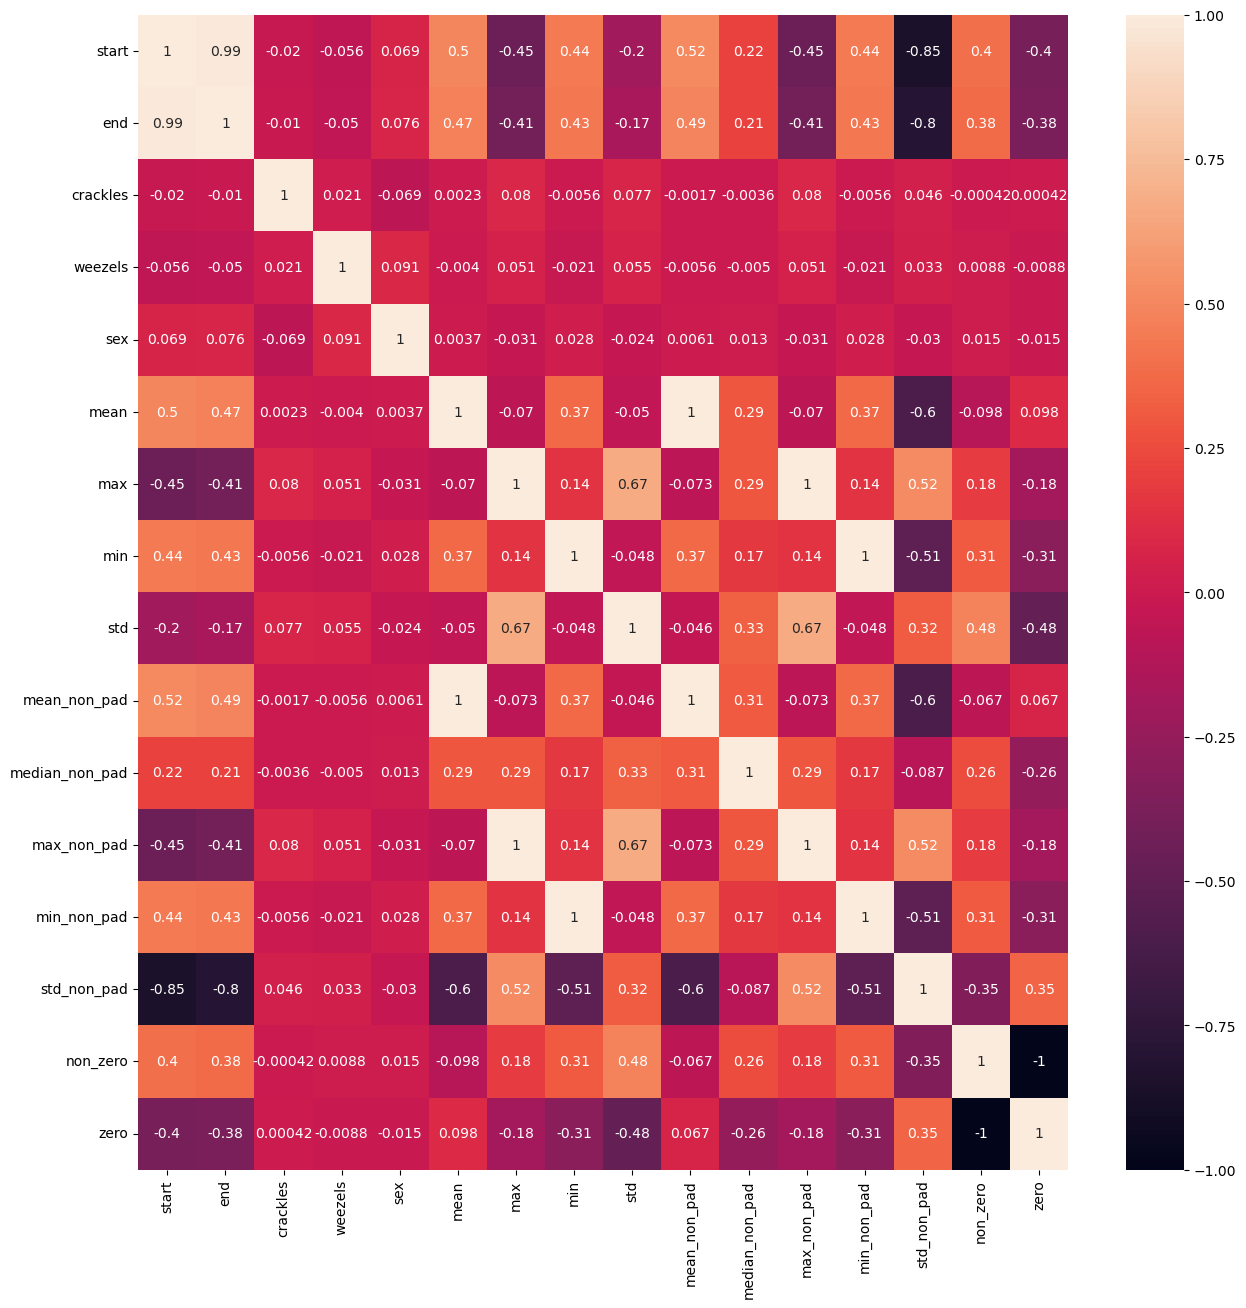

In [201]:
plt.figure(figsize = (15,15))
sns.heatmap(reg_df.drop(columns = ['diag1']).corr('spearman'), annot = True)
plt.show()

In [202]:
'''
Remove End and Start
'''
reg_df.drop(columns = ['zero','mean','end', 'max_non_pad', 'min_non_pad'], inplace = True)

In [203]:
#reg_df.drop(columns = ['std_non_pad'], inplace = True)

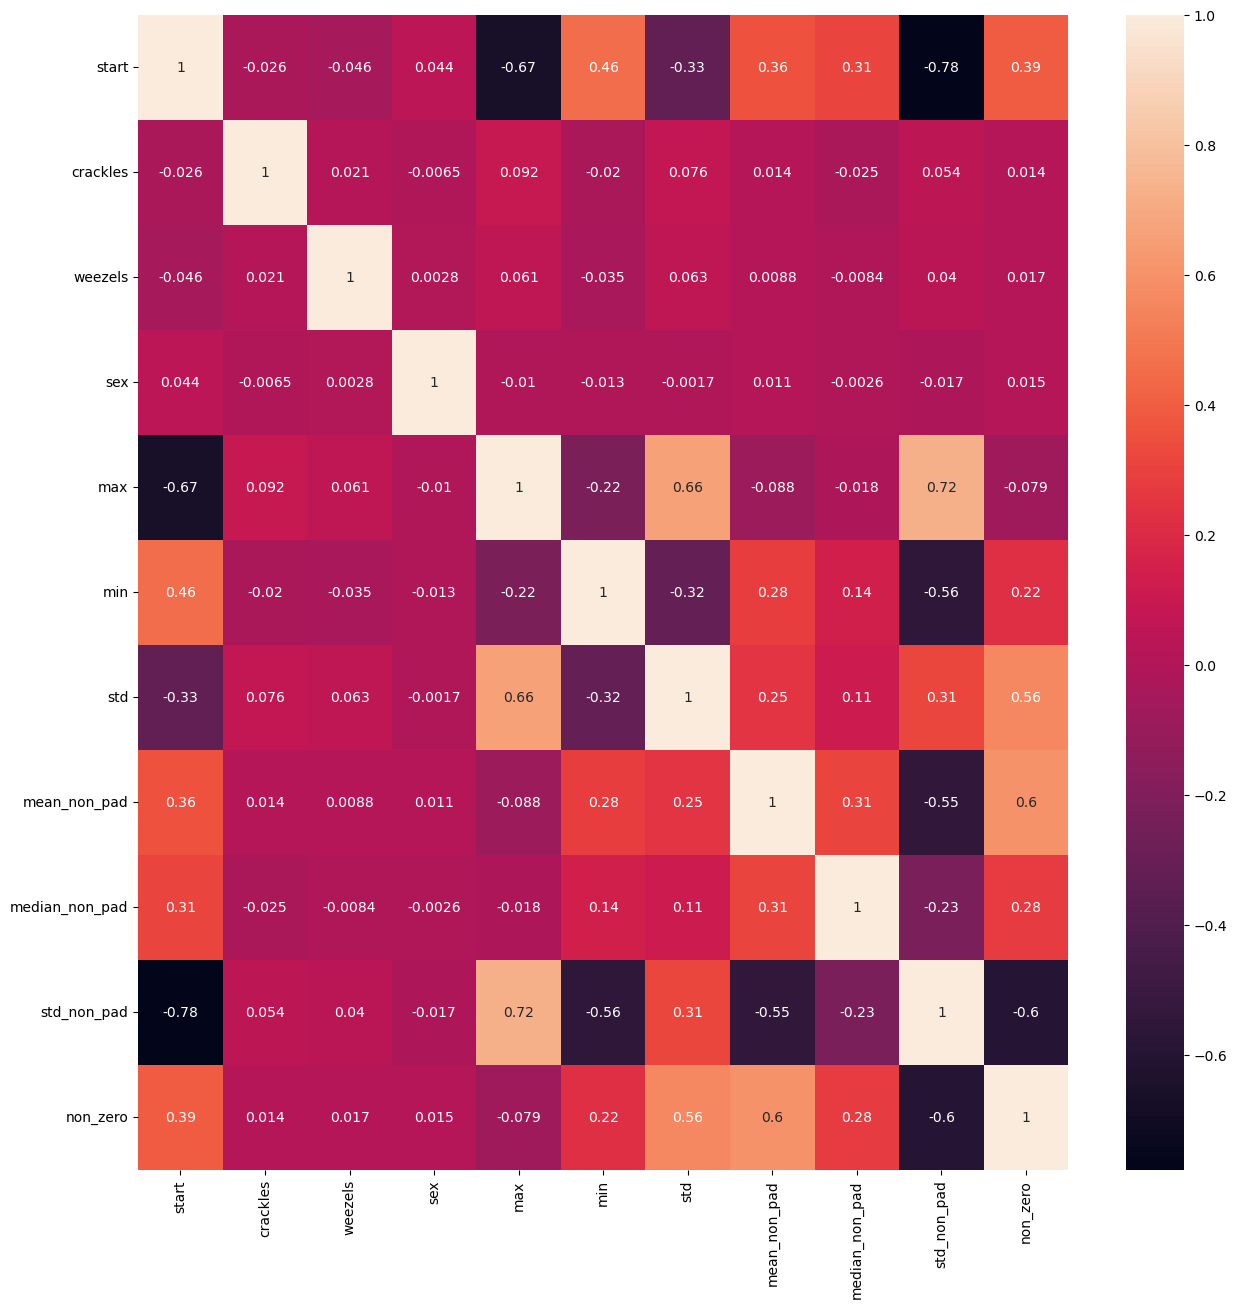

In [204]:
plt.figure(figsize = (15,15))
sns.heatmap(reg_df.drop(columns = ['diag1']).corr(), annot = True)
plt.show()

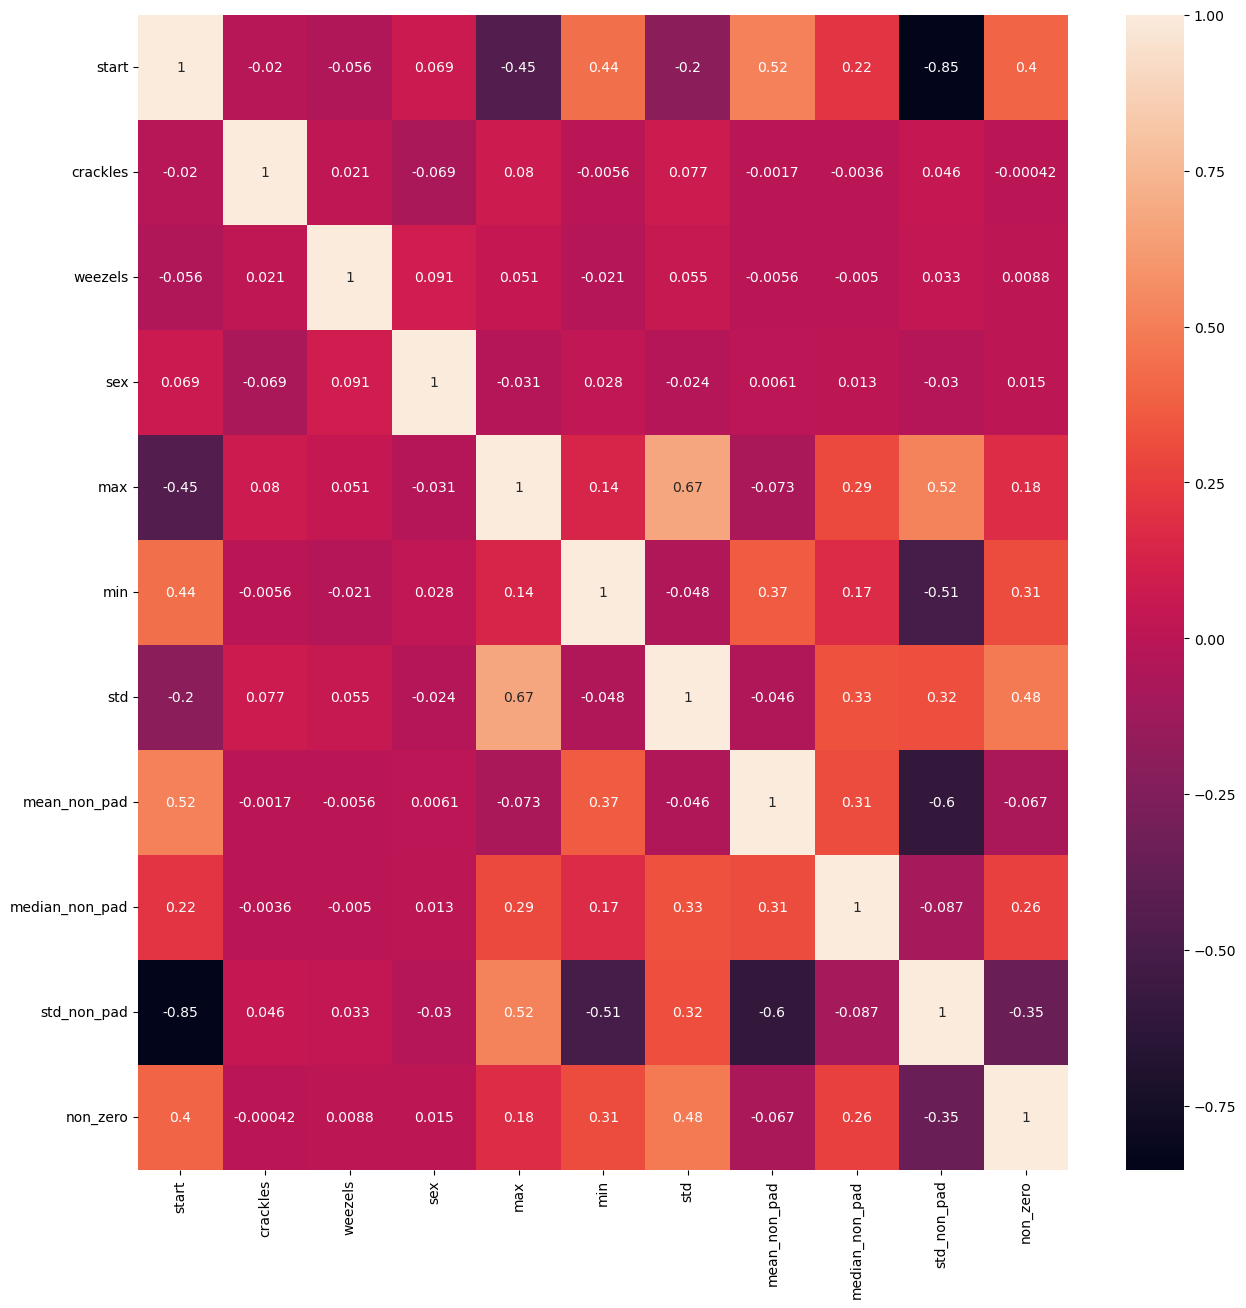

In [205]:
plt.figure(figsize = (15,15))
sns.heatmap(reg_df.drop(columns = ['diag1']).corr('spearman'), annot = True)
plt.show()

## Chi2 and ANOVA

In [206]:
cat_feat = ['crackles', 'weezels', 'sex']
target_feat = ['diag1']

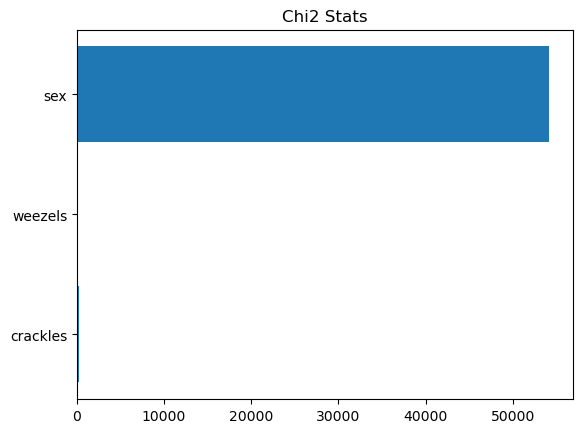

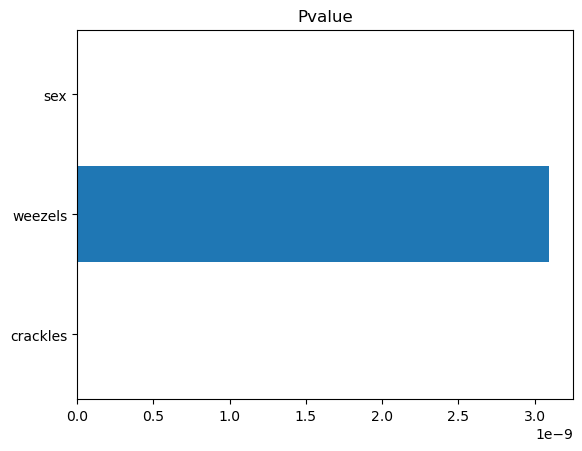

fstat        pvalue  alpha  chosen
crackles    263.596626  2.822006e-59   0.05    True
weezels      35.122879  3.095426e-09   0.05    True
sex       54211.628234  0.000000e+00   0.05    True

In [207]:
'''
categorical columns
'''
fs = SelectKBest(score_func=chi2, k='all')
X_train = reg_df[cat_feat]
y_train = reg_df[target_feat]
alpha = 0.05

fs.fit(X_train, y_train)
#X_train_fs = fs.transform(X_train)

#Create Dataframe
cat_feat_chi2 = pd.DataFrame(np.array([fs.scores_, fs.pvalues_]).T, columns = ['fstat', 'pvalue'], index = X_train.columns)
cat_feat_chi2['alpha'] = alpha
cat_feat_chi2['chosen'] = cat_feat_chi2['pvalue'] <= cat_feat_chi2['alpha']

# plot the scores
plt.barh(X_train.columns, fs.scores_)
plt.title('Chi2 Stats')
plt.show()

plt.barh(X_train.columns, fs.pvalues_)
plt.title('Pvalue')
plt.show()

cat_feat_chi2

In [176]:
reg_df.columns

Index(['start', 'crackles', 'weezels', 'age', 'sex', 'diag1', 'max', 'min',
       'std', 'mean_non_pad', 'median_non_pad', 'std_non_pad', 'non_zero'],
      dtype='object')

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


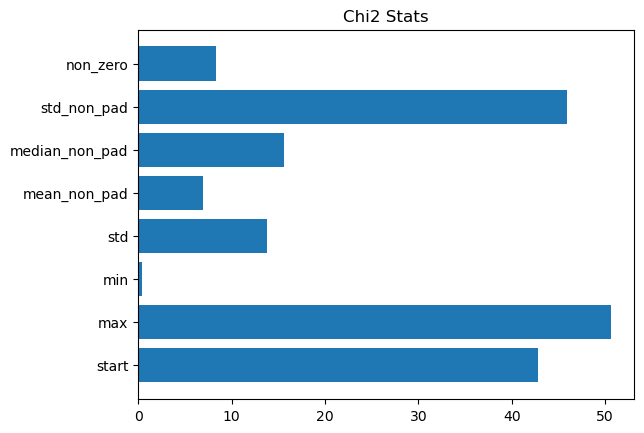

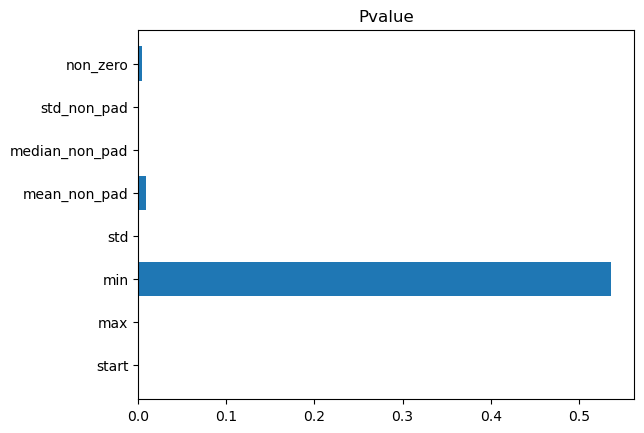

fstat        pvalue  alpha  chosen
start           42.831756  6.393659e-11   0.05    True
max             50.568030  1.266868e-12   0.05    True
min              0.383049  5.359967e-01   0.05   False
std             13.740032  2.115774e-04   0.05    True
mean_non_pad     6.944969  8.424339e-03   0.05    True
median_non_pad  15.618419  7.826999e-05   0.05    True
std_non_pad     45.933775  1.324324e-11   0.05    True
non_zero         8.343187  3.883416e-03   0.05    True

In [211]:
'''
numerical columns
'''
num_feat_anovas = []
target_features = ['diag1']
num_feats = ['start', 'max', 'min',
             'std', 'mean_non_pad', 'median_non_pad', 'std_non_pad',
             'non_zero']

X_train = reg_df[cat_feat]
y_train = reg_df[num_feats]

fs = SelectKBest(score_func=f_classif, k='all')
X_train = reg_df[num_feats]
y_train = reg_df[target_feat]
alpha = 0.05

fs.fit(X_train, y_train)
#X_train_fs = fs.transform(X_train)

...
#create Dataframe
num_feat_anova = pd.DataFrame(np.array([fs.scores_, fs.pvalues_]).T, columns = ['fstat', 'pvalue'], index = X_train.columns)
num_feat_anova['alpha']  = alpha
num_feat_anova['chosen'] = num_feat_anova['pvalue'] <= num_feat_anova['alpha']

# plot the scores
plt.barh(X_train.columns, fs.scores_)
plt.title('Chi2 Stats')
plt.show()

plt.barh(X_train.columns, fs.pvalues_)
plt.title('Pvalue')
plt.show()

num_feat_anova

In [178]:
reg_df['crackles'].value_counts()

0    4528
1    2370
Name: crackles, dtype: int64

# EDA

In [212]:
reg_df['crackles'].value_counts()

0    4528
1    2370
Name: crackles, dtype: int64

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


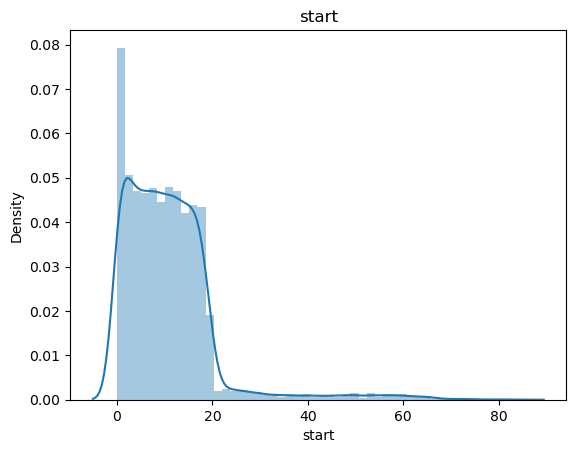

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


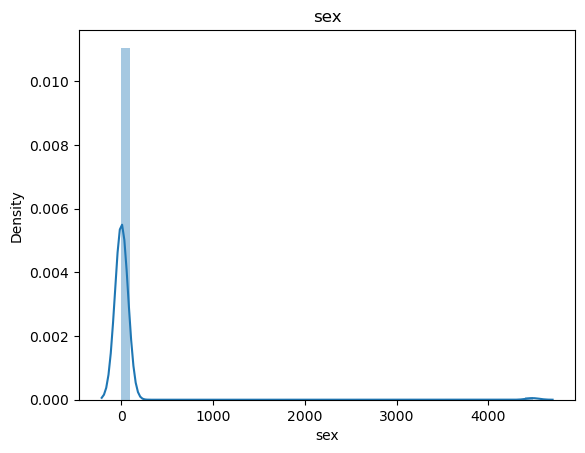

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


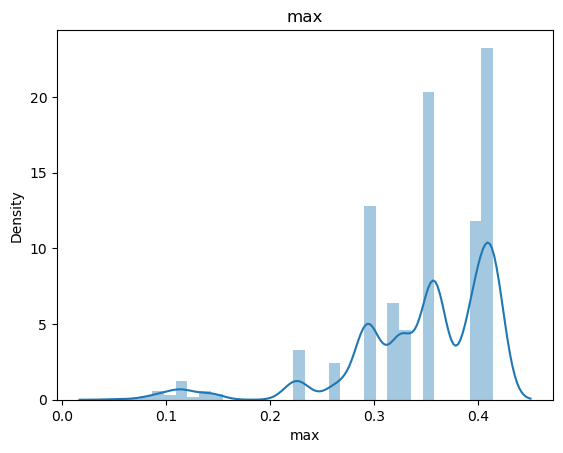

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


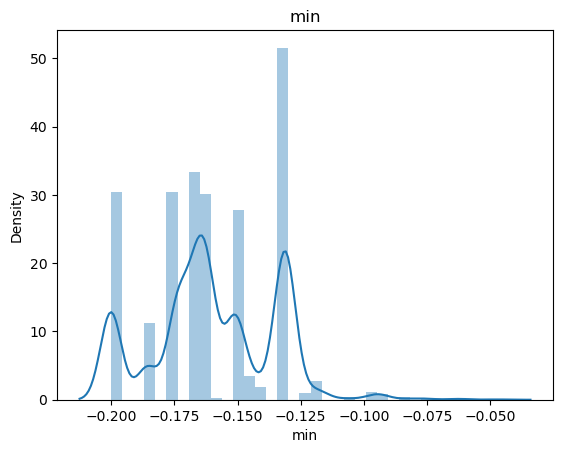

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


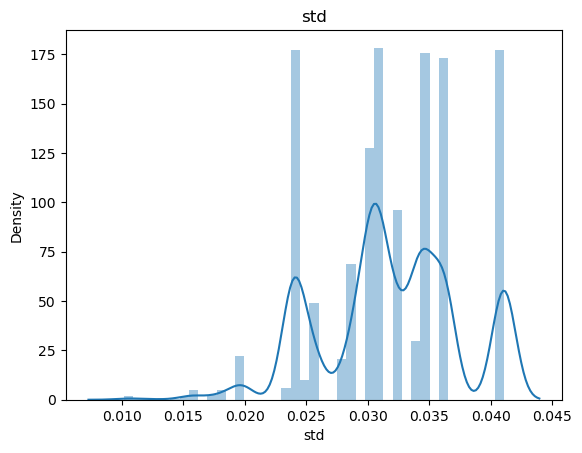

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


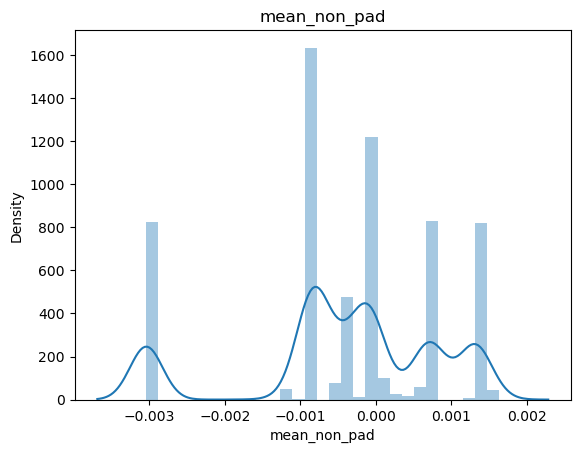

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


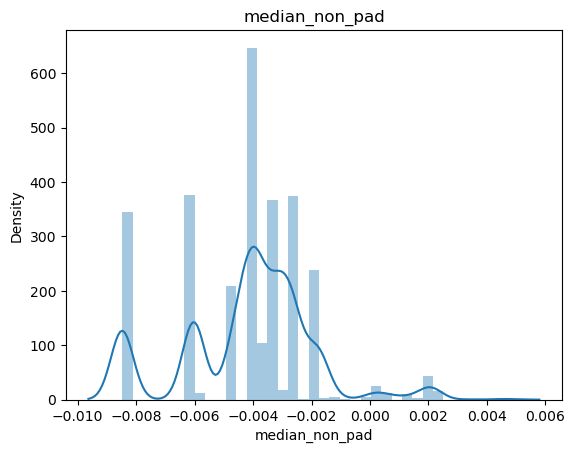

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


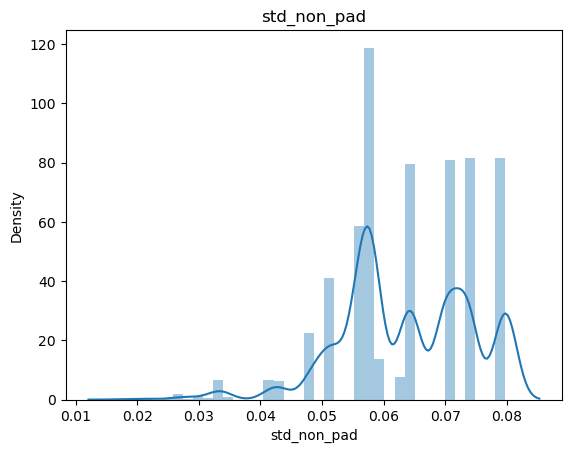

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


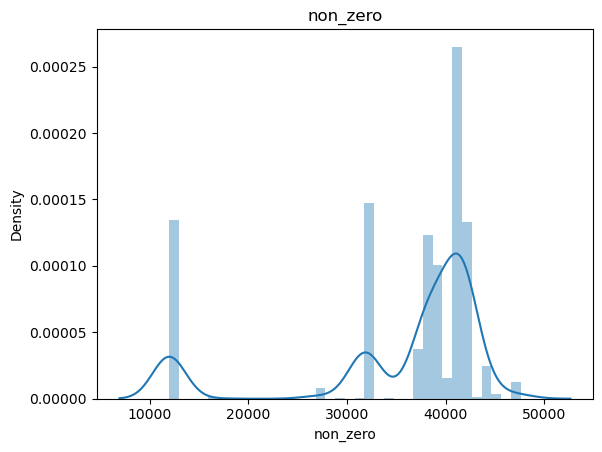

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


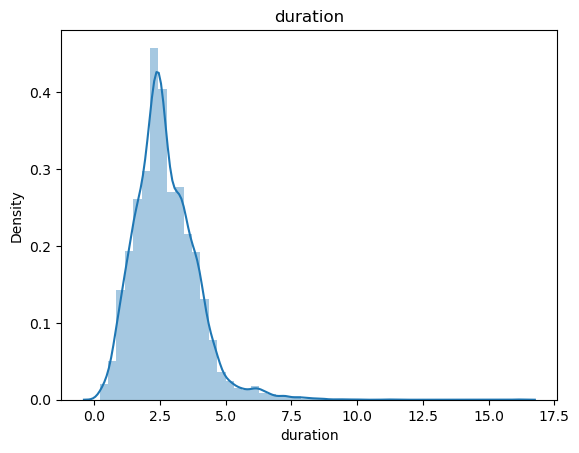

In [255]:
for feature in features1: 
    plt.figure()
    sns.distplot(reg_df[feature])
    plt.title(feature)
    plt.show()

# Cross Validation Modeling

## Adjusted Proportion

In [318]:
diag_0 = reg_df[reg_df['diag1'] == 0]
diag_1 = reg_df[reg_df['diag1'] == 1].sample(round(len(diag_0)*1.5), 
                                             random_state = 42)
diag_concat = pd.concat((diag_0, diag_1))
diag_concat['diag1'].value_counts() / len(diag_concat)

1    0.6
0    0.4
Name: diag1, dtype: float64

In [31]:
'''
Features [Remove end and start column]
'''

features1 = ['start', 
             'sex','max', 'min', 
             'std', 'mean_non_pad', 'median_non_pad', 'std_non_pad',
             'non_zero', 'duration']
target = 'diag1'

X1, y1 = diag_concat[features1], diag_concat[target]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 41, test_size = 0.33, stratify = y1)

In [210]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score

# prepare models
models = []
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
# models.append(('XGB', XGBRegressor(
#     learning_rate = 0.01,
#     n_estimators = 1000,
#     max_depth = 3,
#     subsample = 0.8,
#     colsample_bytree = 1,
#     gamma = 1)))

results1 = []
names1 = []
scoring = ['accuracy', 
           make_scorer(precision_score, pos_label=1), 
           make_scorer(recall_score, pos_label=1),
           make_scorer(precision_score, pos_label=0), 
           make_scorer(recall_score, pos_label=0)]
seed = 7 


for name, model in models:
    cv_results = []
    #kfold = KFold(n_splits=10, random_state=seed, shuffle = True)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_results.append(cross_val_score(model, X_train1, y_train1, cv=kfold, scoring=scoring[0], verbose = 2)) #accuracy scoring
    cv_results.append(cross_val_score(model, X_train1, y_train1, cv=kfold, scoring=scoring[1], verbose = 2)) #
    cv_results.append(cross_val_score(model, X_train1, y_train1, cv=kfold, scoring=scoring[2], verbose = 2)) #
    cv_results.append(cross_val_score(model, X_train1, y_train1, cv=kfold, scoring=scoring[3], verbose = 2)) #
    cv_results.append(cross_val_score(model, X_train1, y_train1, cv=kfold, scoring=scoring[4], verbose = 2))
    results1.append(cv_results)
    names1.append(name)
    
    msg = f'{name}\nACCURACY:{cv_results[0].mean()}\nPRECISION:{cv_results[1].mean()}\nRECALL: {cv_results[2].mean()}'
    print(msg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.3s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.3s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.3s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.3s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.3s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.4s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.3s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.3s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
SVC
ACCURACY:0.5997922063903282
PRECISION:0.5997922063903282
RECALL: 1.0
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END ...........................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
LR
ACCURACY:0.6236156088082901
PRECISION:0.6494338754521223
RECALL: 0.8107046476761619
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
ADA
ACCURACY:0.6988341968911918
PRECISION:0.7125960978789844
RECALL: 0.8358170914542729
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ............

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
LDA
ACCURACY:0.6708198402417962
PRECISION:0.6696046088565746
RECALL: 0.8928560719640177
[CV] END ............

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavio

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, 

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
KNN
ACCURACY:0.7050437176165804
PRECISION:0.7446841900092246
RECALL: 0.7744227886056972
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ............

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
RF
ACCURACY:0.7828125000000001
PRECISION:0.8042527312188126
RECALL: 0.8539955022488754


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
GB
ACCURACY:0.73823402417962
PRECISION:0.746518755335891
RECALL: 0.8566041979010495


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


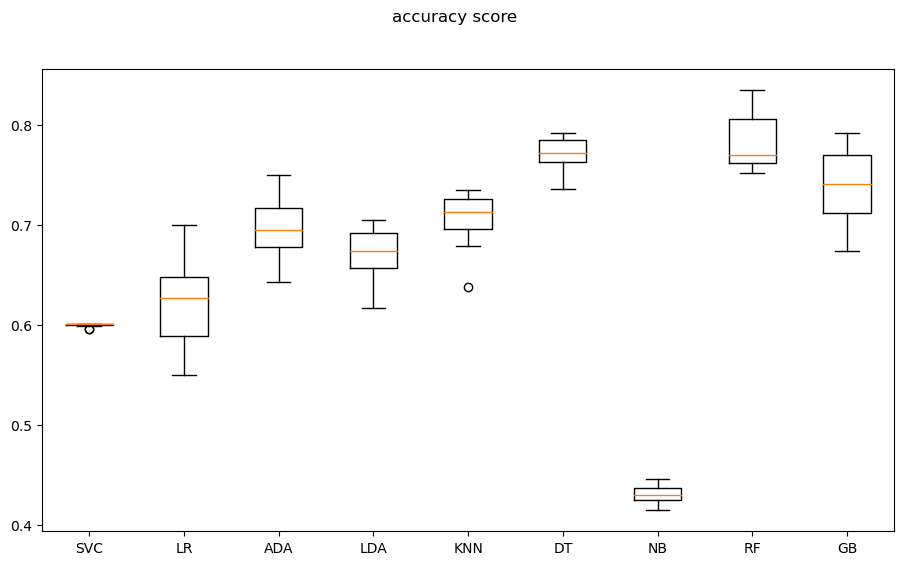

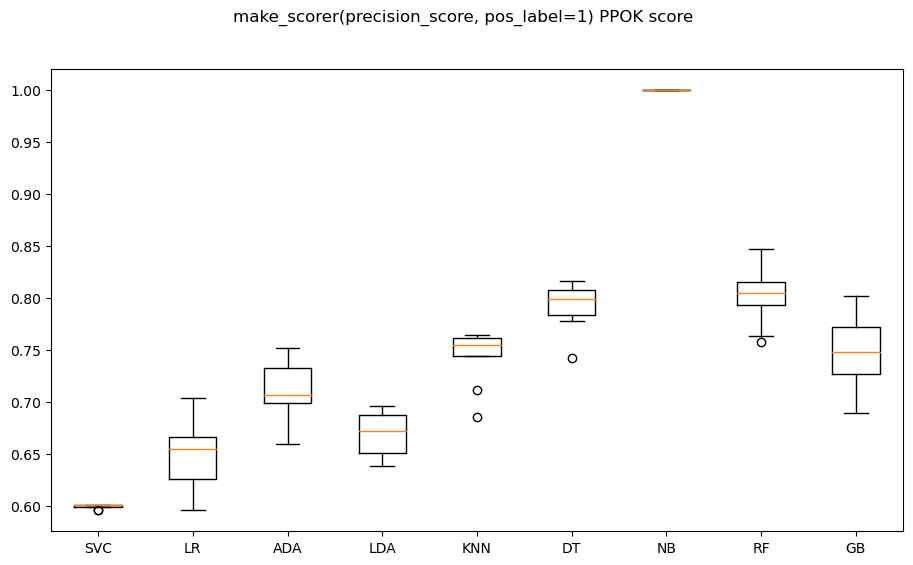

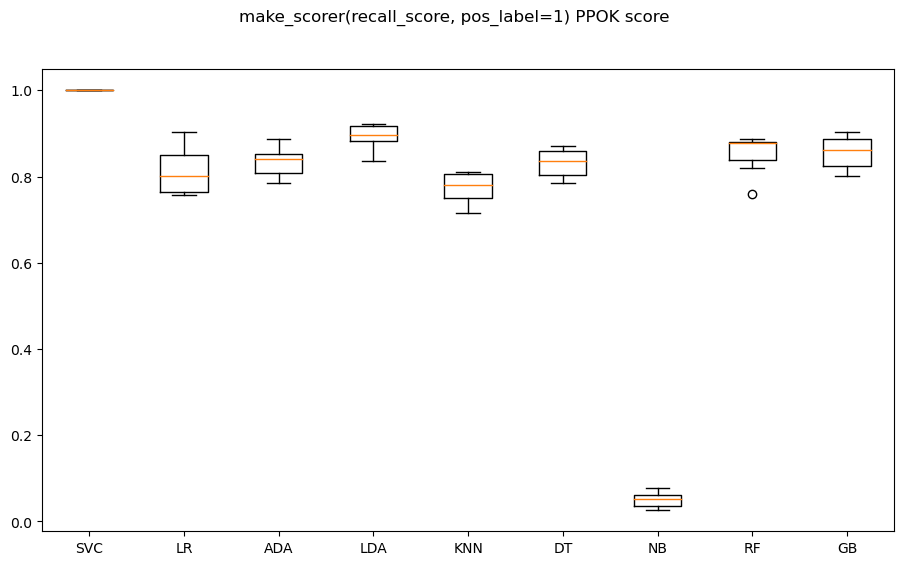

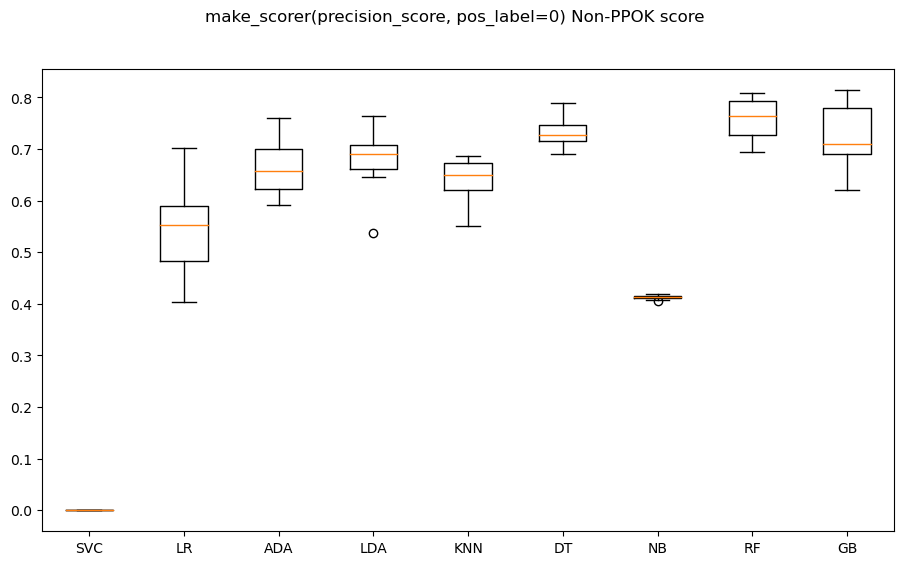

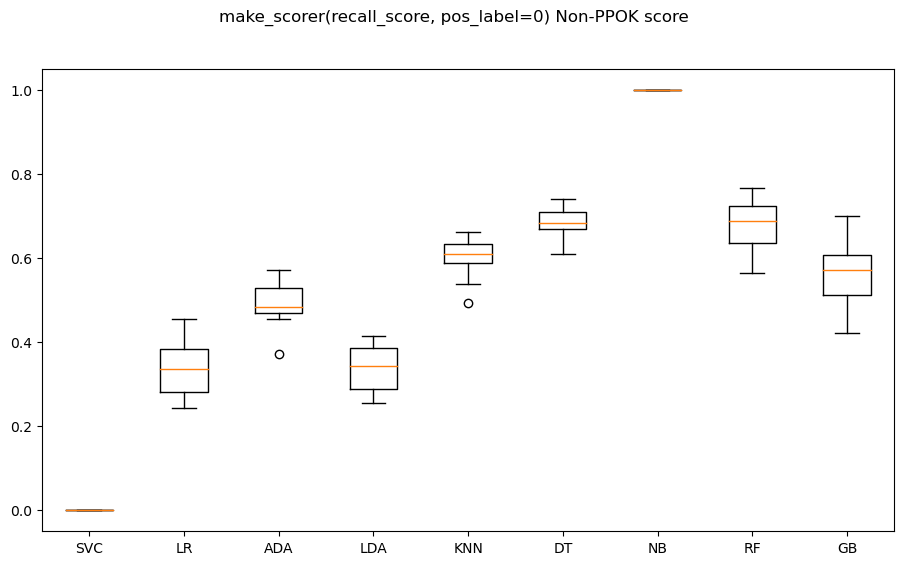

In [211]:
fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[0]} score')
ax = fig.add_subplot(111)
plt.boxplot([result[0] for result in results1])
ax.set_xticklabels(names1)
plt.show()

fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[1]} PPOK score')
ax = fig.add_subplot(111)
plt.boxplot([result[1] for result in results1])
ax.set_xticklabels(names1)
plt.show()

fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[2]} PPOK score')
ax = fig.add_subplot(111)
plt.boxplot([result[2] for result in results1])
ax.set_xticklabels(names1)
plt.show()

fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[3]} Non-PPOK score')
ax = fig.add_subplot(111)
plt.boxplot([result[3] for result in results1])
ax.set_xticklabels(names1)
plt.show()

fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[4]} Non-PPOK score')
ax = fig.add_subplot(111)
plt.boxplot([result[4] for result in results1])
ax.set_xticklabels(names1)
plt.show()

In [212]:
pd.DataFrame(np.transpose([[result[0].mean() for result in results1], 
              [result[1].mean() for result in results1], 
              [result[2].mean() for result in results1],
              [result[3].mean() for result in results1], 
              [result[4].mean() for result in results1]
                ]), 
             index = names1, 
             columns = ['accuracy_mean', 
                        'ppok_precision_mean', 
                        'ppok_recall_mean', 
                       'non_ppok_precision_mean', 
                       'non_ppok_recall_mean']).sort_values(by = ['accuracy_mean', 'ppok_precision_mean', 'ppok_recall_mean', 'non_ppok_precision_mean', 'non_ppok_recall_mean'],
                                                               ascending = False)

accuracy_mean  ppok_precision_mean  ppok_recall_mean  \
RF        0.782813             0.804253          0.853996   
DT        0.770358             0.793829          0.832309   
GB        0.738234             0.746519          0.856604   
KNN       0.705044             0.744684          0.774423   
ADA       0.698834             0.712596          0.835817   
LDA       0.670820             0.669605          0.892856   
LR        0.623616             0.649434          0.810705   
SVC       0.599792             0.599792          1.000000   
NB        0.430797             1.000000          0.050975   

     non_ppok_precision_mean  non_ppok_recall_mean  
RF                  0.758148              0.680103  
DT                  0.732197              0.685248  
GB                  0.723527              0.561006  
KNN                 0.640695              0.601049  
ADA                 0.667546              0.493690  
LDA                 0.678844              0.338295  
LR                  0.550414              0.343407  
SVC                 0.000000              0.000000  
NB                  0.412875              1.000000

## Unadjusted Proportion

In [23]:
'''
Features [Remove end and start column]
'''

features2 = ['mean', 'median', 'max', 'min', 'std',
            'mean_non_pad', 'median_non_pad', 'max_non_pad', 'min_non_pad',
            'std_non_pad', 'non_zero', 'zero', 'duration']
target = 'diag1'

X2, y2 = reg_df[features2], reg_df[target]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 42, test_size = 0.33)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score

# prepare models
models = []
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
# models.append(('XGB', XGBRegressor(
#     learning_rate = 0.01,
#     n_estimators = 1000,
#     max_depth = 3,
#     subsample = 0.8,
#     colsample_bytree = 1,
#     gamma = 1)))

results2 = []
names2 = []
scoring = ['accuracy', 
           make_scorer(precision_score, pos_label=1), 
           make_scorer(recall_score, pos_label=1),
           make_scorer(precision_score, pos_label=0), 
           make_scorer(recall_score, pos_label=0)]
seed = 7 


for name, model in models:
    cv_results = []
    kfold = KFold(n_splits=10, random_state=seed, shuffle = True)
    cv_results.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring[0], verbose = 2)) #accuracy scoring
    cv_results.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring[1], verbose = 2)) #
    cv_results.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring[2], verbose = 2)) #
    cv_results.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring[3], verbose = 2)) #
    cv_results.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring[4], verbose = 2))
    results2.append(cv_results)
    names2.append(name)
    
    msg = f'{name}\nACCURACY:{cv_results[0].mean()}\nPRECISION:{cv_results[1].mean()}\nRECALL: {cv_results[2].mean()}'
    print(msg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.7s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.7s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.7s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.7s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.7s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.7s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.7s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   0.7s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
SVC
ACCURACY:0.8314231484857835
PRECISION:0.8314231484857835
RECALL: 1.0
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...........................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precisi

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
ADA
ACCURACY:0.8498158069432368
PRECISION:0.8578154618034644
RECALL: 0.9822779210449524
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ............

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV] END .................................................... total time=   0.0s
LDA
ACCURACY:0.8366137462249773
PRECISION:0.8426725884825649
RECALL: 0.9879773136139972
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, 

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
KNN
ACCURACY:0.8500303871794153
PRECISION:0.875368064286907
RECALL: 0.955687136324087
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
DT
ACCURACY:0.8506792703336978
PRECISION:0.8993127033415146
RECALL: 0.9286698875701545
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .............

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Paral

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
RF
ACCURACY:0.8669092966069207
PRECISION:0.8939826479587099
RECALL: 0.9529103968523648


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
GB
ACCURACY:0.8558745430235712
PRECISION:0.8630339255160688
RECALL: 0.9815181410331885


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


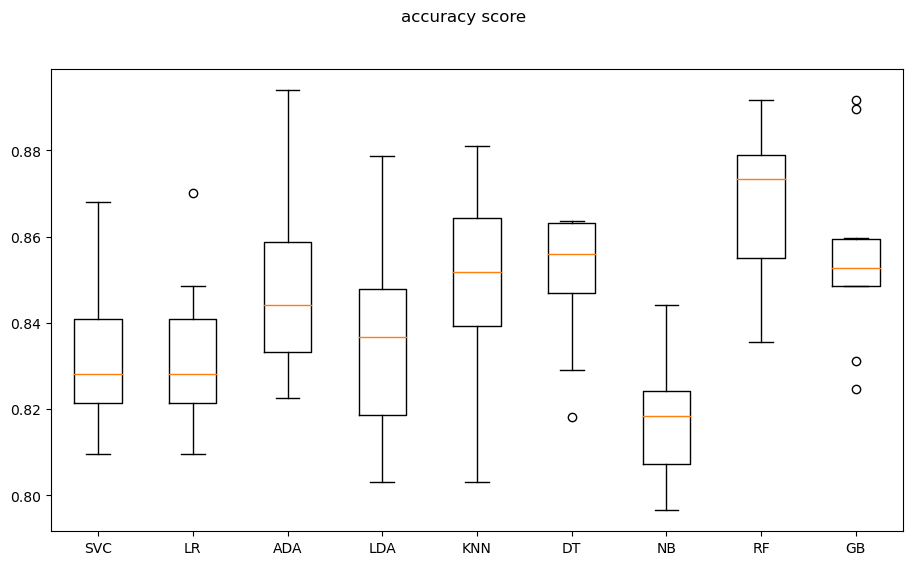

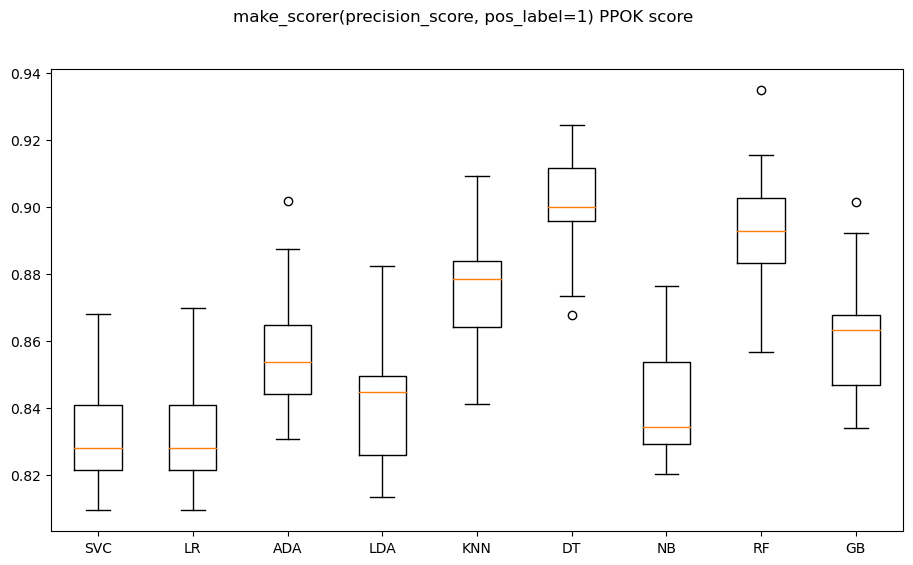

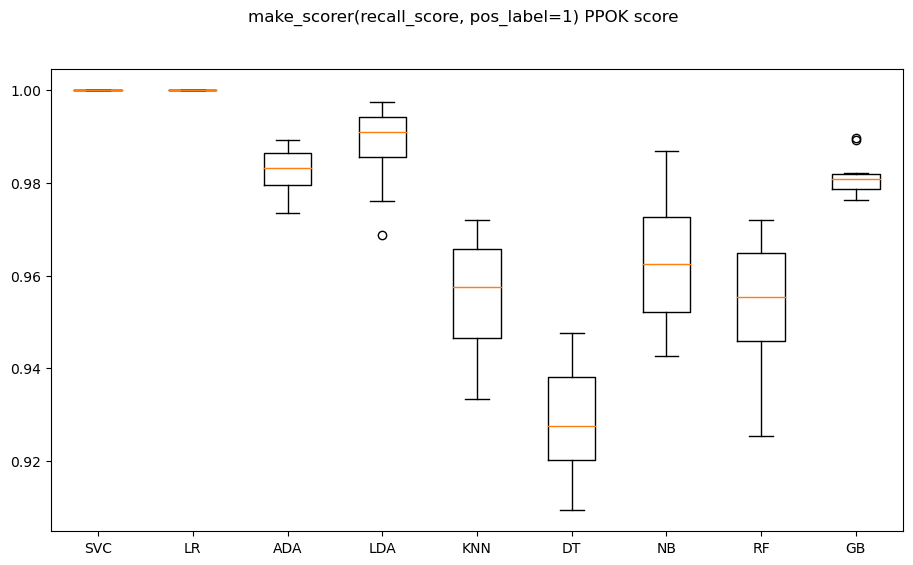

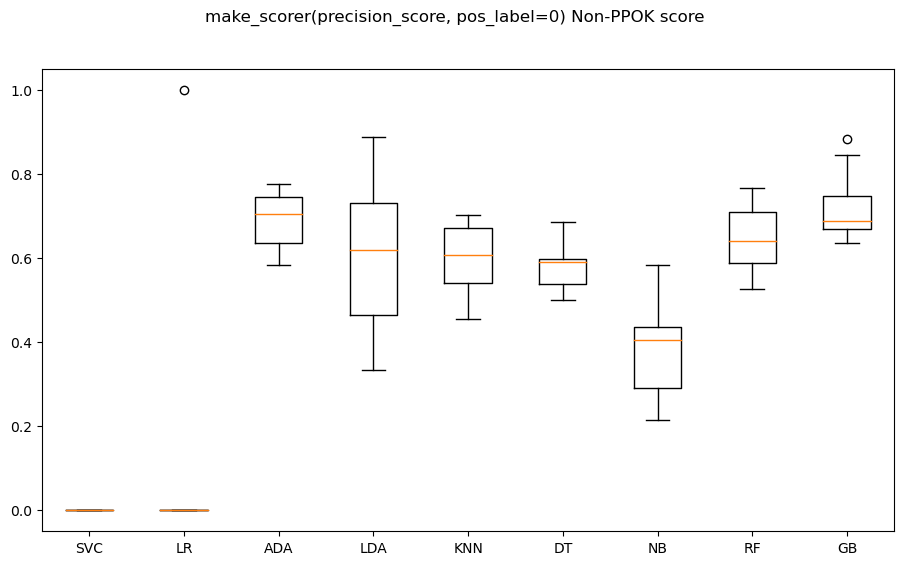

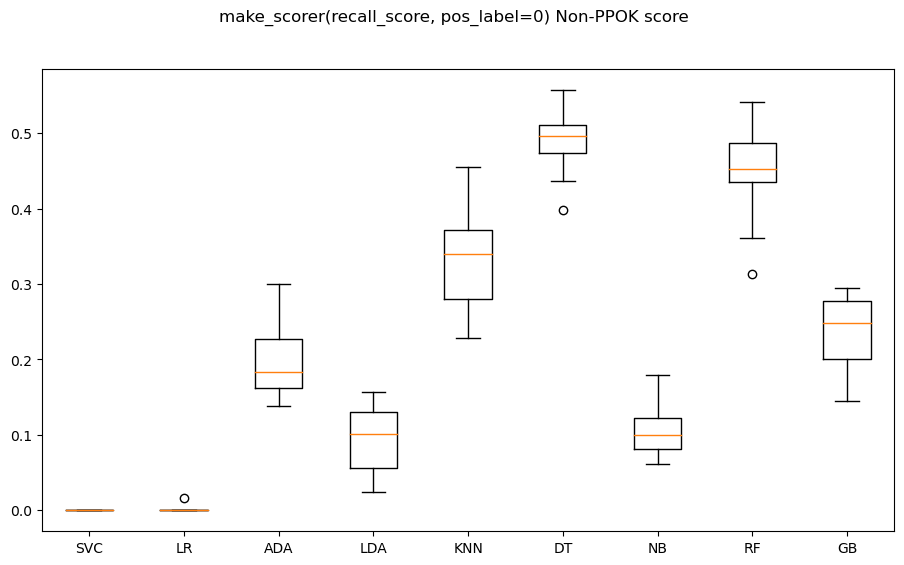

In [39]:
fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[0]} score')
ax = fig.add_subplot(111)
plt.boxplot([result[0] for result in results2])
ax.set_xticklabels(names)
plt.show()

fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[1]} PPOK score')
ax = fig.add_subplot(111)
plt.boxplot([result[1] for result in results2])
ax.set_xticklabels(names)
plt.show()

fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[2]} PPOK score')
ax = fig.add_subplot(111)
plt.boxplot([result[2] for result in results2])
ax.set_xticklabels(names)
plt.show()

fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[3]} Non-PPOK score')
ax = fig.add_subplot(111)
plt.boxplot([result[3] for result in results2])
ax.set_xticklabels(names)
plt.show()

fig = plt.figure(figsize=(11,6))
fig.suptitle(f'{scoring[4]} Non-PPOK score')
ax = fig.add_subplot(111)
plt.boxplot([result[4] for result in results2])
ax.set_xticklabels(names)
plt.show()

In [41]:
pd.DataFrame(np.transpose([[result[0].mean() for result in results2], 
              [result[1].mean() for result in results2], 
              [result[2].mean() for result in results2],
              [result[3].mean() for result in results2], 
              [result[4].mean() for result in results2]
                ]), 
             index = names2, 
             columns = ['accuracy_mean', 
                        'ppok_precision_mean', 
                        'ppok_recall_mean', 
                       'non_ppok_precision_mean', 
                       'non_ppok_recall_mean']).sort_values(by = ['accuracy_mean', 'ppok_precision_mean', 'ppok_recall_mean', 'non_ppok_precision_mean', 'non_ppok_recall_mean'],
                                                               ascending = False)

accuracy_mean  ppok_precision_mean  ppok_recall_mean  \
RF        0.866909             0.893983          0.952910   
GB        0.855875             0.863034          0.981518   
DT        0.850679             0.899313          0.928670   
KNN       0.850030             0.875368          0.955687   
ADA       0.849816             0.857815          0.982278   
LDA       0.836614             0.842673          0.987977   
LR        0.831640             0.831611          1.000000   
SVC       0.831423             0.831423          1.000000   
NB        0.818437             0.841959          0.962665   

     non_ppok_precision_mean  non_ppok_recall_mean  
RF                  0.647492              0.448024  
GB                  0.721875              0.233596  
DT                  0.583980              0.490852  
KNN                 0.602062              0.330140  
ADA                 0.692852              0.200724  
LDA                 0.607877              0.092484  
LR                  0.100000              0.001639  
SVC                 0.000000              0.000000  
NB                  0.383085              0.109417

# Model Testing

## RF Testing

In [228]:
fig = plt.figure(figsize=(25,20))
dt = RandomForestClassifier(random_state = 42).fit(X_train1, y_train1)
y_pred = dt.predict(X_test1)
print(classification_report(y_test1,y_pred))
# _ = tree.plot_tree(dt, 
#                    feature_names= features1,  
#                    class_names=target,
#                    filled=True)

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       380
           1       0.81      0.83      0.82       571

    accuracy                           0.78       951
   macro avg       0.77      0.77      0.77       951
weighted avg       0.78      0.78      0.78       951



<Figure size 2500x2000 with 0 Axes>

In [235]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70,  None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}

In [224]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train1, y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [226]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=100, n_estimators=800, random_state=42)

In [240]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_gs = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_gs.fit(X_train1, y_train1)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   5.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   6.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   2.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400,
                                          1600, 1800, 2000]},
             verbose=2)

In [242]:
rf_gs.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [245]:
rf = RandomForestClassifier(random_state=42).fit(X_train1, y_train1)
y_pred = rf.predict(X_test1)
print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       380
           1       0.81      0.83      0.82       571

    accuracy                           0.78       951
   macro avg       0.77      0.77      0.77       951
weighted avg       0.78      0.78      0.78       951

[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   7.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=  10.8s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   5.0s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=12

In [232]:
rf = RandomForestClassifier(max_depth=100, n_estimators=1000, random_state=42).fit(X_train1, y_train1)
y_pred = rf.predict(X_test1)
print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       380
           1       0.81      0.83      0.82       571

    accuracy                           0.78       951
   macro avg       0.77      0.77      0.77       951
weighted avg       0.78      0.78      0.78       951



In [244]:
rf = RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=200, random_state=42v).fit(X_train1, y_train1)
y_pred = rf.predict(X_test1)
print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71       380
           1       0.81      0.81      0.81       571

    accuracy                           0.77       951
   macro avg       0.76      0.76      0.76       951
weighted avg       0.77      0.77      0.77       951



## DT Testing

### GridSearch and RandomSearch

In [255]:
diag_concat['diag1'].value_counts()

1    1722
0    1148
Name: diag1, dtype: int64

In [376]:
'''
Features [Remove end and start column]
'''

features1 = [#'start', 
             'sex','max', 'crackles', 'weezels',#'min',# 'age',
             'std',  'median_non_pad', 'mean_non_pad','std_non_pad', #'mean_non_pad',
             'non_zero']#, 'duration']
target = 'diag1'

diag_0 = reg_df[reg_df['diag1'] == 0]
diag_1 = reg_df[reg_df['diag1'] == 1].sample(round(len(diag_0)*1.5), 
                                             random_state = 42)
diag_concat = pd.concat((diag_0, diag_1))
print(diag_concat['diag1'].value_counts() / len(diag_concat))

'''min	1.102296	2.938212e-01	0.05	False
std	0.468475	4.937260e-01	0.05	False
mean_non_pad	3.039440	8.133468e-02	0.05	False
median_non_pad	1.734350	1.879258e-01	0.05	False
non_zero	3.757141	5.264714e-02	0.05	False'''

X1, y1 = diag_concat[features1], diag_concat[target]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 41, test_size = 0.33, stratify = y1)

1    0.6
0    0.4
Name: diag1, dtype: float64


In [322]:
print(X_train1.shape)
print(X_test1.shape)

(1929, 9)
(951, 9)


In [323]:
print(X_train1.shape)
print(X_test1.shape)

(1929, 9)
(951, 9)


In [324]:
y_train1.value_counts()/ len(y_train1)

1    0.599793
0    0.400207
Name: diag1, dtype: float64

In [260]:
from sklearn.ensemble import RandomForestRegressor
dt = DecisionTreeClassifier(random_state=42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(dt.get_params())

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Number of trees in random forest
ccp_alpha= [0.01, 0.05, 0.1]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'ccp_alpha': ccp_alpha,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)
{'max_depth': [10, 30, 50, 70,  None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'ccp_alpha': [0.01, 0.05, 0.1]}

Parameters currently in use:

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}
{'ccp_alpha': [0.01, 0.05, 0.1], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


{'max_depth': [10, 30, 50, 70, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'ccp_alpha': [0.01, 0.05, 0.1]}

In [142]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dt_random.fit(X_train1, y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.01, 0.05, 0.1],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=2)

In [144]:
dt_random.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=20, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [345]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(ccp_alpha=0.01, max_depth=20, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42).fit(X_train1, y_train1)

y_pred_train = dt.predict(X_train1)
y_pred = dt.predict(X_test1)

print(classification_report(y_train1,y_pred_train))
print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       772
           1       0.60      1.00      0.75      1157

    accuracy                           0.60      1929
   macro avg       0.30      0.50      0.37      1929
weighted avg       0.36      0.60      0.45      1929

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       380
           1       0.60      1.00      0.75       571

    accuracy                           0.60       951
   macro avg       0.30      0.50      0.38       951
weighted avg       0.36      0.60      0.45       951



/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [262]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_gs = GridSearchCV(estimator = dt, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
dt_gs.fit(X_train1, y_train1)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


KeyboardInterrupt: 

In [145]:
dt_gs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=20, max_features='auto',
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [344]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(ccp_alpha=0.01, max_depth=20, max_features='auto',
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42).fit(X_train1, y_train1)

y_pred_train = dt.predict(X_train1)
y_pred = dt.predict(X_test1)

print(classification_report(y_train1,y_pred_train))
print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       772
           1       0.60      1.00      0.75      1157

    accuracy                           0.60      1929
   macro avg       0.30      0.50      0.37      1929
weighted avg       0.36      0.60      0.45      1929

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       380
           1       0.60      1.00      0.75       571

    accuracy                           0.60       951
   macro avg       0.30      0.50      0.38       951
weighted avg       0.36      0.60      0.45       951



/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [346]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,ccp_alpha=0.0025).fit(X_train1, y_train1)

y_pred_train = dt.predict(X_train1)
y_pred = dt.predict(X_test1)

print(classification_report(y_train1,y_pred_train))
print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       772
           1       0.81      0.79      0.80      1157

    accuracy                           0.77      1929
   macro avg       0.76      0.76      0.76      1929
weighted avg       0.77      0.77      0.77      1929

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       380
           1       0.79      0.76      0.77       571

    accuracy                           0.73       951
   macro avg       0.72      0.73      0.72       951
weighted avg       0.74      0.73      0.73       951



### Testing Features Combination

In [209]:
'''
Features [Remove end and start column]
'''

features1 = ['start', 
             'sex','max', 'crackles', 'weezels',#'min',# 'age',
             'std',  'median_non_pad', 'mean_non_pad','std_non_pad', #'mean_non_pad',
             'non_zero', 'duration']
target = 'diag1'

diag_0 = reg_df[reg_df['diag1'] == 0]
diag_1 = reg_df[reg_df['diag1'] == 1].sample(round(len(diag_0)*1.5), 
                                             random_state = 42)
diag_concat = pd.concat((diag_0, diag_1))
print(diag_concat['diag1'].value_counts() / len(diag_concat))

X1, y1 = diag_concat[features1], diag_concat[target]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 41, test_size = 0.33, stratify = y1)

'''
Feature Importances
'''

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,ccp_alpha=0.0025).fit(X_train1, y_train1)

y_pred_train = dt.predict(X_train1)
y_pred = dt.predict(X_test1)

print(classification_report(y_train1,y_pred_train))
print(classification_report(y_test1,y_pred))
#confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test1, y_pred)
#sns.heatmap(confusion_matrix(y_test1,y_pred))
plt.show()

from sklearn.inspection import permutation_importance
# get importance
results = permutation_importance(dt, X1, y1, scoring='precision')
importance = results.importances_mean

# plot feature importance
plt.barh([features1[x] for x in range(len(importance))], importance)
plt.title('Feature Importances Based on Precision')
plt.show()


# get importance
results = permutation_importance(dt, X1, y1, scoring='recall')
importance = results.importances_mean

# plot feature importance
plt.barh([features1[x] for x in range(len(importance))], importance)
plt.title('Feature Importances Based on Recall')
plt.show()


# get importance
results = permutation_importance(dt, X1, y1, scoring='accuracy')
importance = results.importances_mean

# plot feature importance
plt.barh([features1[x] for x in range(len(importance))], importance)
plt.title('Feature Importances Based on Accuracy')
plt.show()


1    0.6
0    0.4
Name: diag1, dtype: float64


KeyError: "['duration'] not in index"

1    0.6
0    0.4
Name: diag1, dtype: float64
Runtime: 0.015441179275512695
              precision    recall  f1-score   support

           0       0.79      0.41      0.54       772
           1       0.70      0.93      0.80      1157

    accuracy                           0.72      1929
   macro avg       0.75      0.67      0.67      1929
weighted avg       0.74      0.72      0.70      1929

              precision    recall  f1-score   support

           0       0.75      0.45      0.56       380
           1       0.71      0.90      0.79       571

    accuracy                           0.72       951
   macro avg       0.73      0.67      0.68       951
weighted avg       0.73      0.72      0.70       951



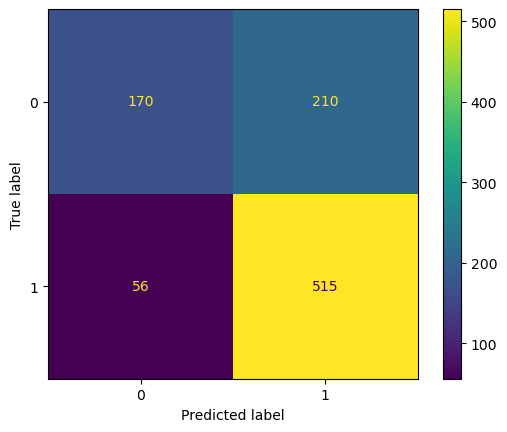

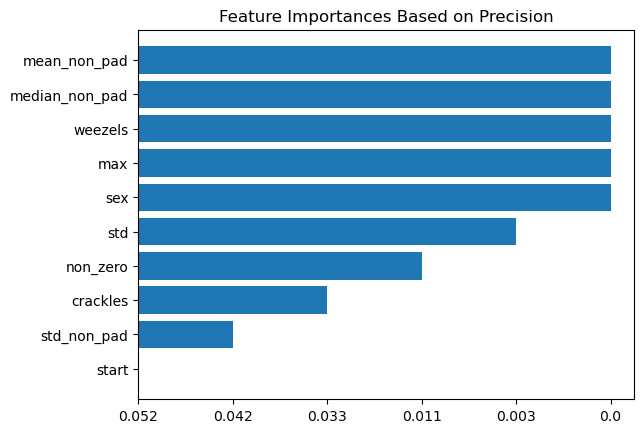

TypeError: barh() missing 1 required positional argument: 'width'

In [461]:
'''
Features
'''
features1 = ['start', 'sex','max', 'crackles', 'weezels','std',
             'median_non_pad', 'mean_non_pad','std_non_pad', 'non_zero']
target = 'diag1'

diag_0 = reg_df[reg_df['diag1'] == 0]
diag_1 = reg_df[reg_df['diag1'] == 1].sample(round(len(diag_0)*1.5),random_state = 42)
diag_concat = pd.concat((diag_0, diag_1))
print(diag_concat['diag1'].value_counts() / len(diag_concat))

X1, y1 = diag_concat[features1], diag_concat[target]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 41, test_size = 0.33, stratify = y1)


'''
Model Training and Prediction
'''
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

start = time.time() #runtime checking
dt = DecisionTreeClassifier(random_state=42,ccp_alpha=0.005).fit(X_train1, y_train1)
end = time.time() #runtime checking
print(f'Runtime: {end-start}')

y_pred_train = dt.predict(X_train1)
y_pred = dt.predict(X_test1)

'''
Classification Report
'''
print(classification_report(y_train1,y_pred_train))
print(classification_report(y_test1,y_pred))

'''
Confusion Matrix
'''
ConfusionMatrixDisplay.from_predictions(y_test1, y_pred)
plt.show()

'''
Feature Importances
'''
# get importance
results = permutation_importance(dt, X1, y1, scoring='precision')
importance = results.importances_mean

# plot feature importance
imp_df = pd.DataFrame(np.array([[features1[x] for x in range(len(importance))], importance.astype(float).round(3)]).T, columns = ['Feature', 'Importances']).sort_values(by = ['Importances'], ascending = False)
plt.barh(imp_df['Feature'], imp_df['Importances'])
plt.title('Feature Importances Based on Precision')
plt.show()


# get importance
results = permutation_importance(dt, X1, y1, scoring='recall')
importance = results.importances_mean

# plot feature importance
imp_df = pd.DataFrame(np.array([[features1[x] for x in range(len(importance))], importance.astype(float).round(3)]).T, columns = ['Feature', 'Importances']).sort_values(by = ['Importances'], ascending = False)
plt.barh([imp_df['Feature'], imp_df['Importances']])
plt.title('Feature Importances Based on Recall')
plt.show()

# get importance
results = permutation_importance(dt, X1, y1, scoring='accuracy')
importance = results.importances_mean

# plot feature importance
imp_df = pd.DataFrame(np.array([[features1[x] for x in range(len(importance))], importance.astype(float).round(3)]).T, columns = ['Feature', 'Importances']).sort_values(by = ['Importances'], ascending = False)
plt.barh(imp_df['Feature'], imp_df['Importances'])
plt.title('Feature Importances Based on Accuracy')
plt.show()


In [444]:
print(importance)
print(importance.round(3))
imp_df = pd.DataFrame(np.array([[features1[x] for x in range(len(importance))], importance.astype(float).round(3)]).T, columns = ['Feature', 'Importances']).sort_values(by = ['Importances'], ascending = False)
imp_df

[0.12268519 0.         0.         0.02152778 0.         0.04699074
 0.         0.         0.04351852 0.06284722]
[0.123 0.    0.    0.022 0.    0.047 0.    0.    0.044 0.063]


Feature Importances
0           start       0.123
9        non_zero       0.063
5             std       0.047
8     std_non_pad       0.044
3        crackles       0.022
1             sex         0.0
2             max         0.0
4         weezels         0.0
6  median_non_pad         0.0
7    mean_non_pad         0.0

Feature Importances
0           start       0.123
9        non_zero       0.063
5             std       0.047
8     std_non_pad       0.044
3        crackles       0.022
1             sex         0.0
2             max         0.0
4         weezels         0.0
6  median_non_pad         0.0
7    mean_non_pad         0.0

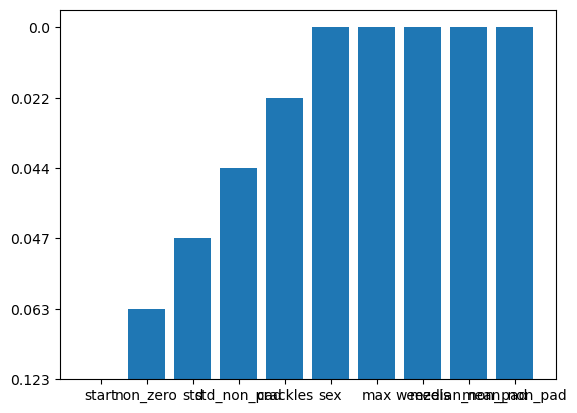

In [460]:
#plt.barh(imp_df['Feature'], imp_df['Importances'])
plt.bar(imp_df['Feature'], imp_df['Importances'])
imp_df

1    0.6
0    0.4
Name: diag1, dtype: float64
              precision    recall  f1-score   support

           0       0.80      0.37      0.51       772
           1       0.69      0.94      0.80      1157

    accuracy                           0.71      1929
   macro avg       0.74      0.65      0.65      1929
weighted avg       0.73      0.71      0.68      1929

              precision    recall  f1-score   support

           0       0.77      0.39      0.52       380
           1       0.70      0.92      0.79       571

    accuracy                           0.71       951
   macro avg       0.73      0.66      0.66       951
weighted avg       0.73      0.71      0.68       951



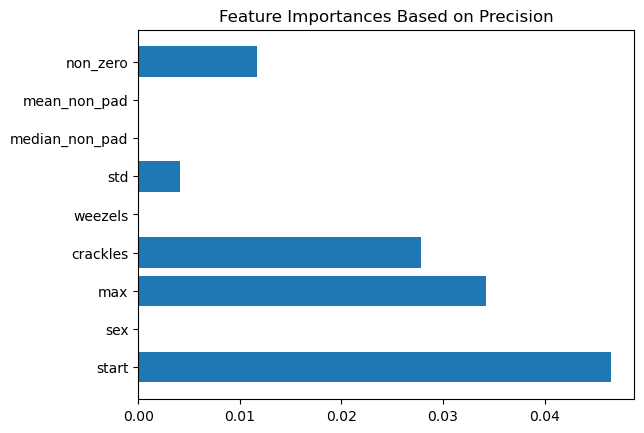

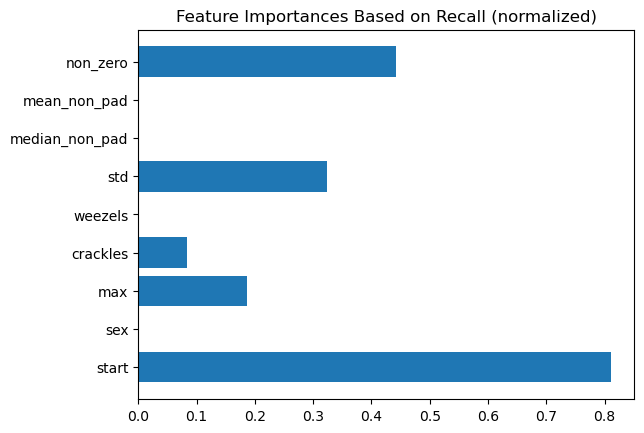

array([0.1337943 , 0.        , 0.03094209, 0.01382887, 0.        ,
       0.05358686, 0.        , 0.        , 0.07312014])

In [210]:
'''
Features
'''
features1 = ['start', 'sex','max', 'crackles', 'weezels','std',
             'median_non_pad', 'mean_non_pad', 'non_zero'] #'std_non_pad'
target = 'diag1'

diag_0 = reg_df[reg_df['diag1'] == 0]
diag_1 = reg_df[reg_df['diag1'] == 1].sample(round(len(diag_0)*1.5),random_state = 42)
diag_concat = pd.concat((diag_0, diag_1))
print(diag_concat['diag1'].value_counts() / len(diag_concat))

X1, y1 = diag_concat[features1], diag_concat[target]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 41, test_size = 0.33, stratify = y1)

'''
Feature Importances
'''
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,ccp_alpha=0.005).fit(X_train1, y_train1)

y_pred_train = dt.predict(X_train1)
y_pred = dt.predict(X_test1)

print(classification_report(y_train1,y_pred_train))
print(classification_report(y_test1,y_pred))


from sklearn.inspection import permutation_importance
# get importance
results = permutation_importance(dt, X1, y1, scoring='precision')
importance = results.importances_mean

# plot feature importance
plt.barh([features1[x] for x in range(len(importance))], importance)
plt.title('Feature Importances Based on Precision')
plt.show()



# get importance
results = permutation_importance(dt, X_train1, y_train1, scoring='recall')
importance = results.importances_mean

# plot feature importance
plt.barh([features1[x] for x in range(len(importance))], importance / np.linalg.norm(importance))
plt.title('Feature Importances Based on Recall (normalized)')
plt.show()


# # get importance
# results = permutation_importance(dt, X1, y1, scoring='accuracy')
# importance = results.importances_mean

# # plot feature importance
# plt.barh([features1[x] for x in range(len(importance))], importance)
# plt.title('Feature Importances Based on Accuracy')
# plt.set_xticklabels(importance)
# plt.bar_label(importance)
# plt.show()
importance

array([0.80983111, 0.        , 0.        , 0.12252057, 0.        ,
       0.30032482, 0.        , 0.        , 0.27716544, 0.40267432])

1    0.6
0    0.4
Name: diag1, dtype: float64


/Users/stevenalexander/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


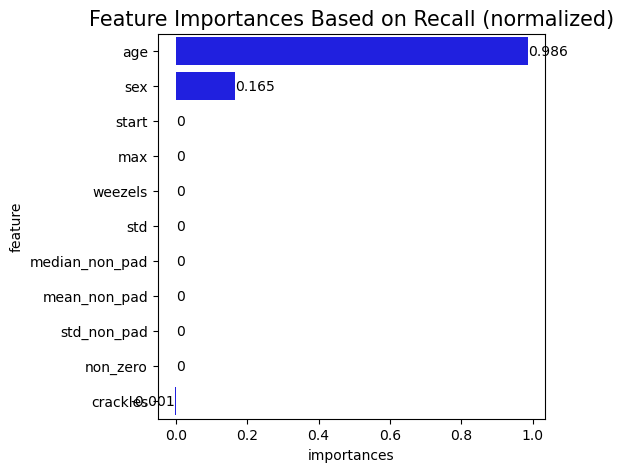

In [181]:
features1 = ['start', 'sex','max', 'crackles', 'weezels','std',
             'median_non_pad', 'mean_non_pad','std_non_pad', 'non_zero', 'age']
target = 'diag1'

diag_0 = reg_df[reg_df['diag1'] == 0]
diag_1 = reg_df[reg_df['diag1'] == 1].sample(round(len(diag_0)*1.5),random_state = 42)
diag_concat = pd.concat((diag_0, diag_1))
print(diag_concat['diag1'].value_counts() / len(diag_concat))

X1, y1 = diag_concat[features1], diag_concat[target]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 41, test_size = 0.33, stratify = y1)

'''
Feature Importances
'''
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,ccp_alpha=0.005).fit(X_train1, y_train1)
results = permutation_importance(dt, X_train1, y_train1, scoring='recall')
importance = results.importances_mean

plot_fi = pd.DataFrame([[features1[x] for x in range(len(importance))], importance / np.linalg.norm(importance)]).T.sort_values(by = [1], ascending = False)
plot_fi.columns = ['feature', 'importances']
plot_fi['importances'] = plot_fi['importances'].apply(lambda row : round(row, 3))

fig, ax = plt.subplots(figsize=(5, 5))

# new helper method to auto-label bars

sns.barplot(plot_fi['importances'], plot_fi['feature'], color = 'b')
plt.title('Feature Importances Based on Recall (normalized)', fontsize = 15)
ax.bar_label(ax.containers[0])
plt.show()


## Class Analysis 

In [147]:
'''
BEFORE USING FEATURE IMPORTANCES FEATURES
'''
features1 = ['start', 'crackles', 'std','std_non_pad', 'non_zero']
target = 'diag1'

diag_0 = reg_df[reg_df['diag1'] == 0]
diag_1 = reg_df[reg_df['diag1'] == 1].sample(round(len(diag_0)*1.5),random_state = 42)
diag_concat = pd.concat((diag_0, diag_1))
print(diag_concat['diag1'].value_counts() / len(diag_concat))

X1, y1 = diag_concat[features1], diag_concat[target]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 41, test_size = 0.33, stratify = y1)

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,ccp_alpha=0.005).fit(X_train1, y_train1)

y_pred_train = dt.predict(X_train1)
y_pred = dt.predict(X_test1)

print(classification_report(y_train1,y_pred_train))
print(classification_report(y_test1,y_pred))

'''
AFTER USING FEATURE IMPORTANCES FEATURES
'''
features1 = ['start', 'max', 'crackles', 'weezels','std',
             'median_non_pad', 'mean_non_pad','std_non_pad', 'non_zero']
target = 'diag1'

diag_0 = reg_df[reg_df['diag1'] == 0]
diag_1 = reg_df[reg_df['diag1'] == 1].sample(round(len(diag_0)*1.5),random_state = 42)
diag_concat = pd.concat((diag_0, diag_1))
print(diag_concat['diag1'].value_counts() / len(diag_concat))

X1, y1 = diag_concat[features1], diag_concat[target]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 41, test_size = 0.33, stratify = y1)
#X_train1['sex'], X_test1['sex'] = X_train1['sex'].replace({'M' : 1, "F" : 0}).astype(int), X_test1['sex'].replace({'M' : 1, "F" : 0}).astype(int)
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,ccp_alpha=0.005).fit(X_train1, y_train1)

y_pred_train = dt.predict(X_train1)
y_pred = dt.predict(X_test1)

print(classification_report(y_train1,y_pred_train))
print(classification_report(y_test1,y_pred))

1    0.6
0    0.4
Name: diag1, dtype: float64
              precision    recall  f1-score   support

           0       0.79      0.41      0.54       772
           1       0.70      0.93      0.80      1157

    accuracy                           0.72      1929
   macro avg       0.75      0.67      0.67      1929
weighted avg       0.74      0.72      0.70      1929

              precision    recall  f1-score   support

           0       0.75      0.45      0.56       380
           1       0.71      0.90      0.79       571

    accuracy                           0.72       951
   macro avg       0.73      0.67      0.68       951
weighted avg       0.73      0.72      0.70       951

1    0.6
0    0.4
Name: diag1, dtype: float64
              precision    recall  f1-score   support

           0       0.79      0.41      0.54       772
           1       0.70      0.93      0.80      1157

    accuracy                           0.72      1929
   macro avg       0.75      0.67   

In [101]:
y1.unique().astype(str)
X_train1.shape

(1929, 5)

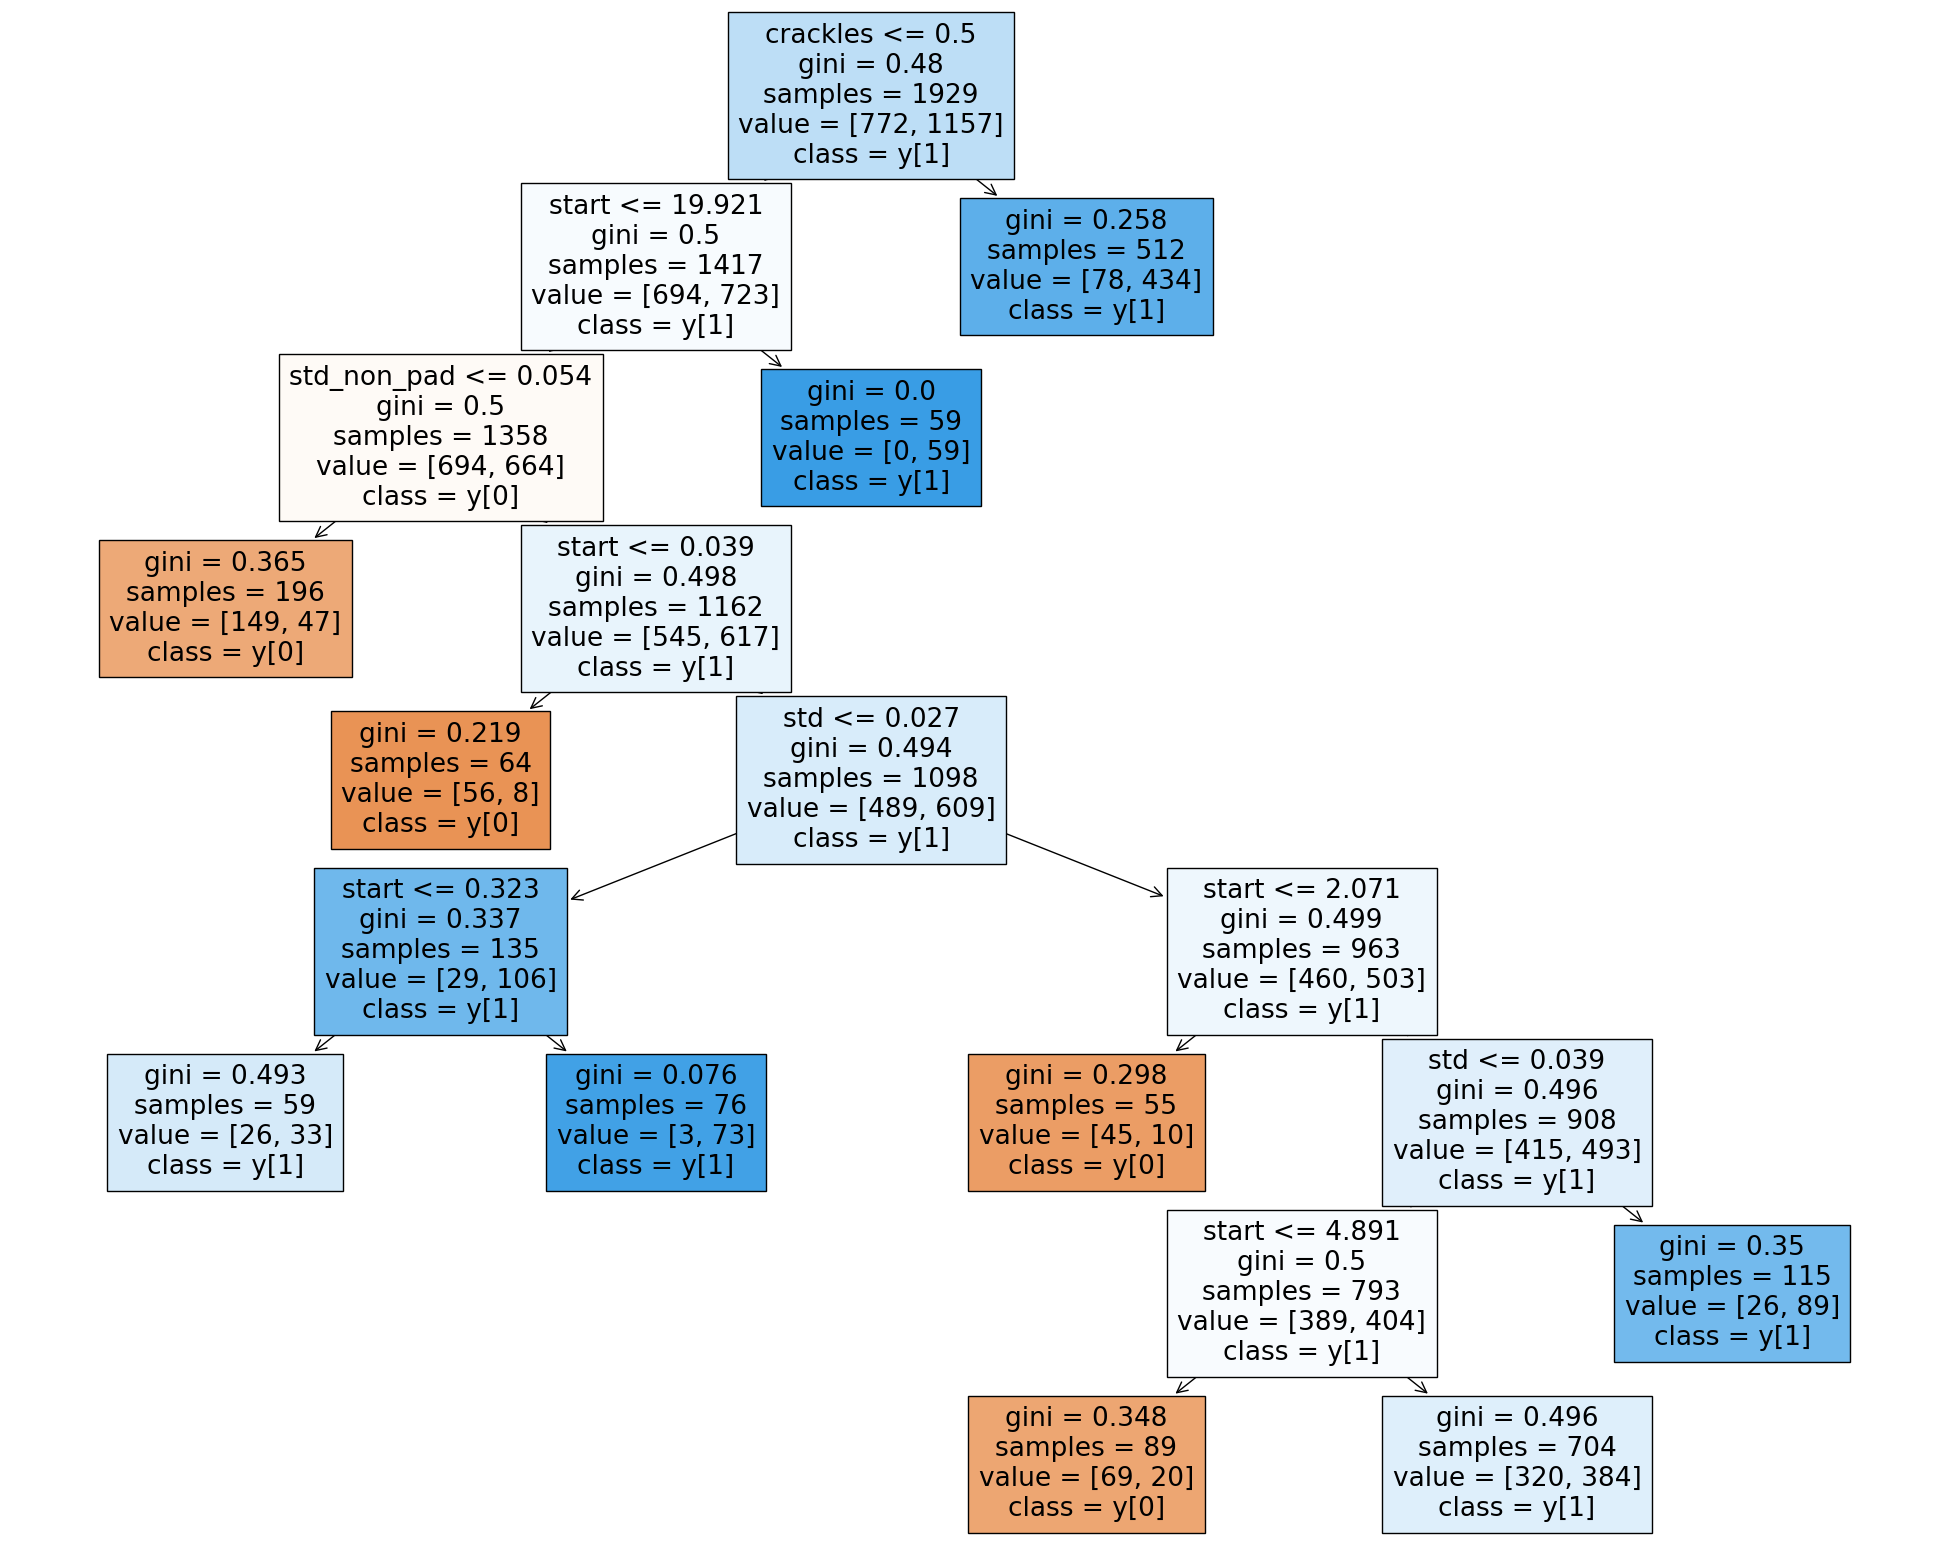

In [142]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=X1.columns,  
                   class_names= True, #['PPOK', 'NON-PPOK'],#y1.unique().astype(str),
                   filled=True)

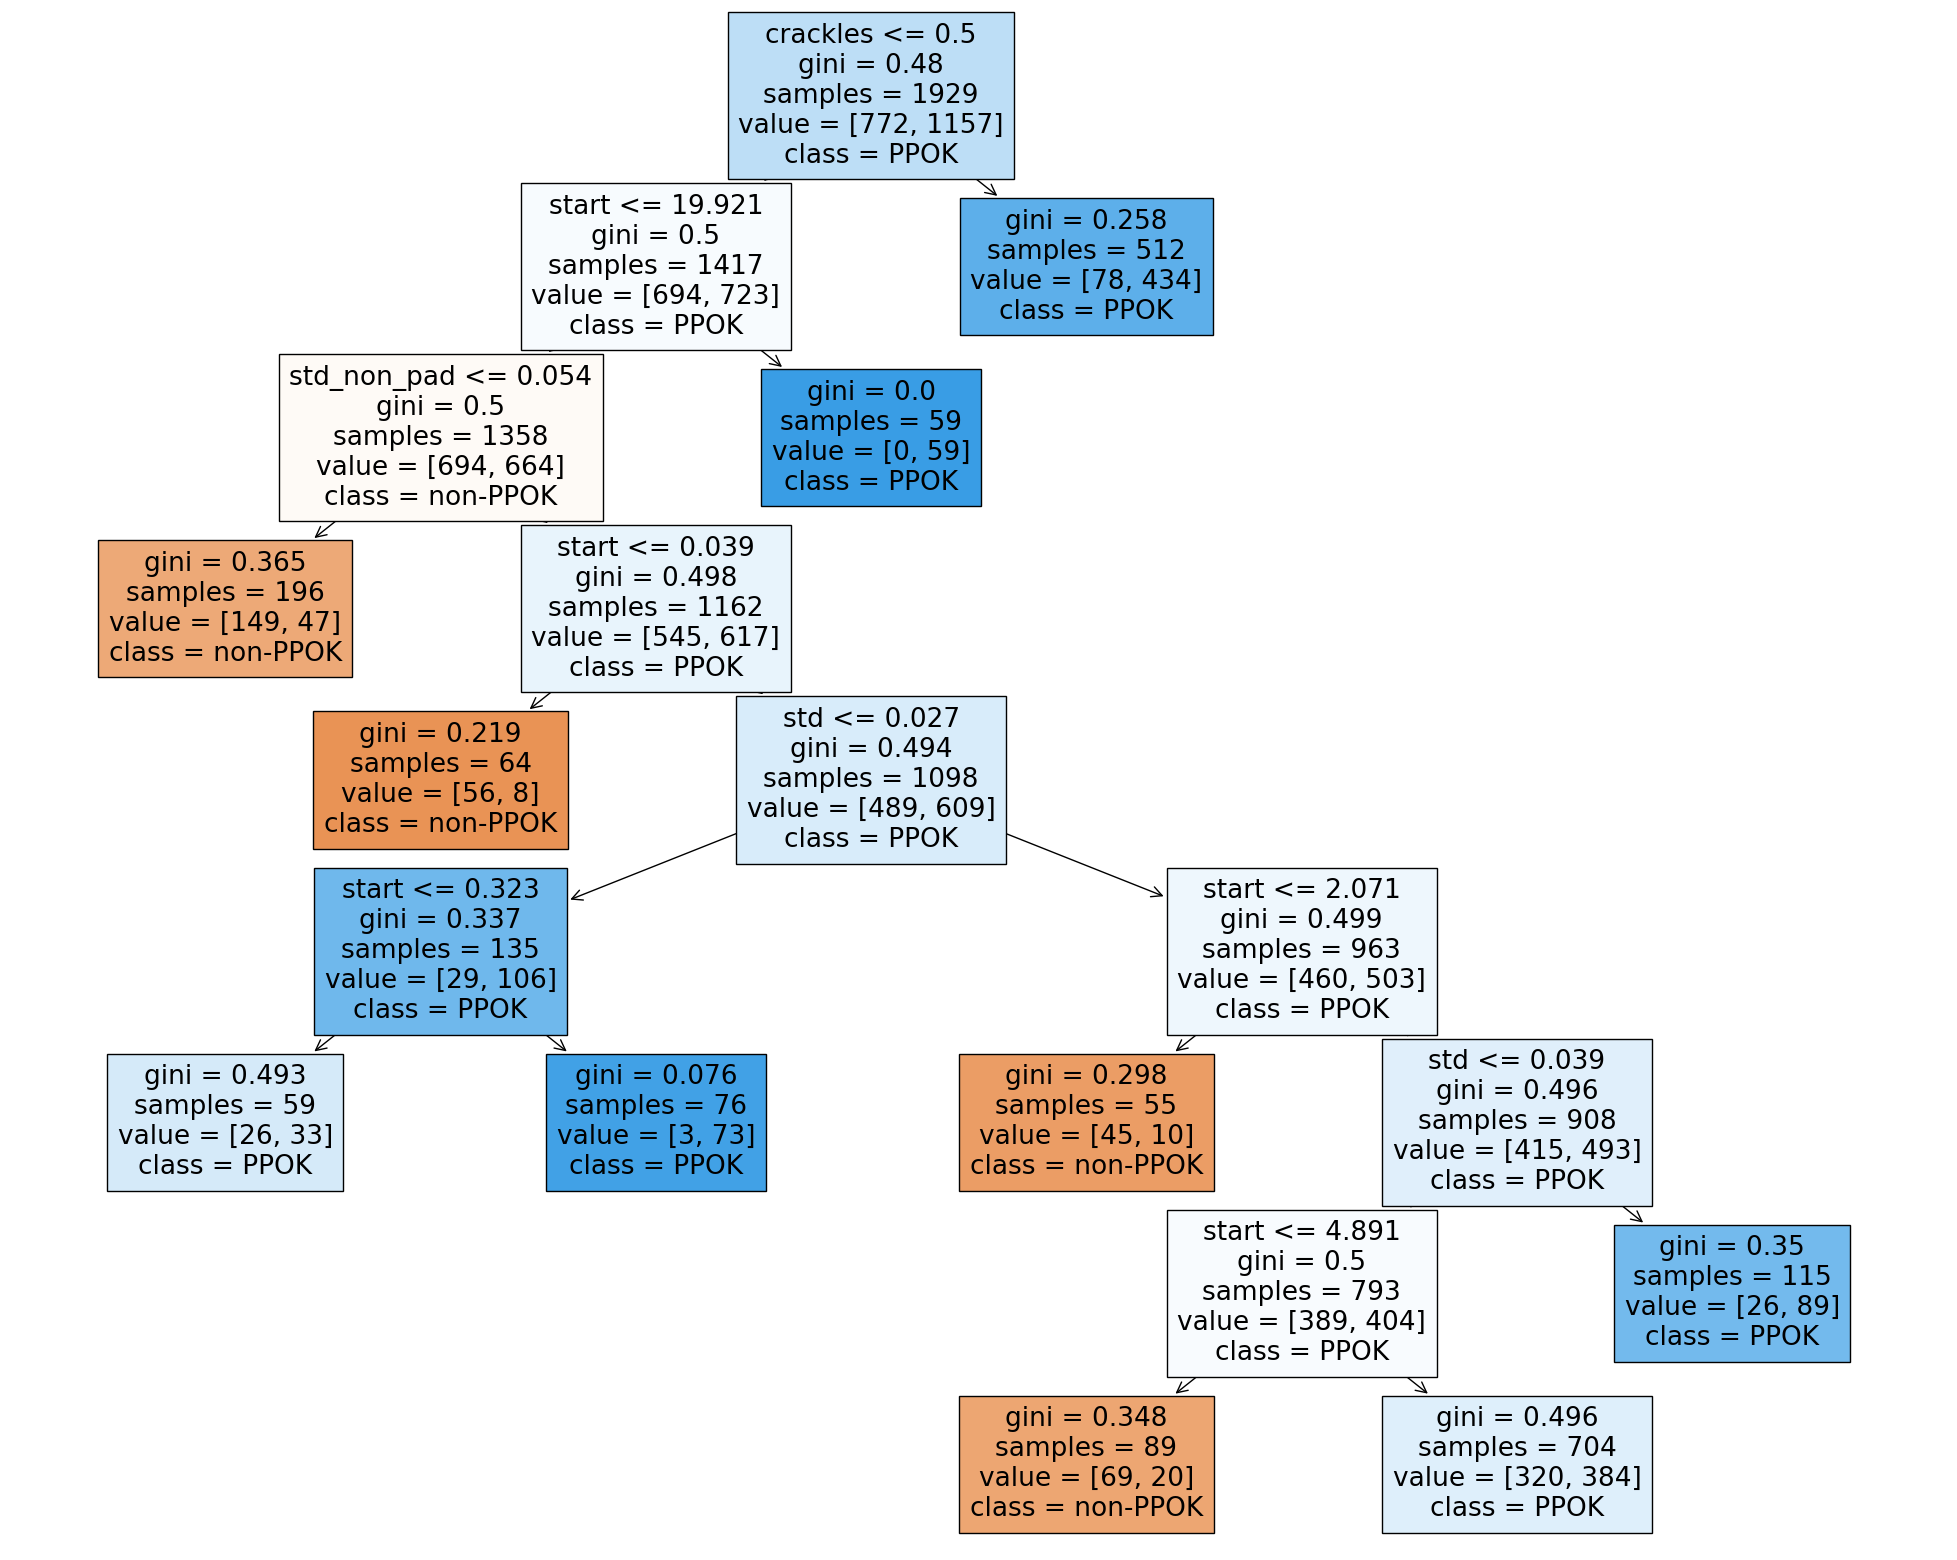

In [143]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=X1.columns,  
                   class_names= ['non-PPOK', 'PPOK'],#y1.unique().astype(str),
                   filled=True)

In [76]:
'''
Features
'''
features1 = ['start', 'sex','max', 'crackles', 'weezels','std',
             'median_non_pad', 'mean_non_pad','std_non_pad', 'non_zero']
target = 'diag1'

diag_0 = reg_df[reg_df['diag1'] == 0]
diag_1 = reg_df[reg_df['diag1'] == 1].sample(round(len(diag_0)*1.5),random_state = 42)
diag_concat = pd.concat((diag_0, diag_1))
print(diag_concat['diag1'].value_counts() / len(diag_concat))

X1, y1 = diag_concat[features1], diag_concat[target]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 41, test_size = 0.33, stratify = y1)

1    0.6
0    0.4
Name: diag1, dtype: float64


In [124]:
X1.shape

(2880, 5)

In [103]:
tot = pd.concat((X_train1[features1], y_train1), axis = 1)
ppok = tot[tot[target] == 1]
non_ppok = tot[tot[target] == 0]
ppok.describe()

start     crackles          std  std_non_pad      non_zero  \
count  1157.000000  1157.000000  1157.000000  1157.000000   1157.000000   
mean     10.753201     0.375108     0.031787     0.064350  34584.013829   
std      10.661659     0.484360     0.005691     0.010681  10330.558712   
min       0.000000     0.000000     0.010178     0.019519  11973.000000   
25%       3.768000     0.000000     0.029009     0.057634  31818.000000   
50%       8.994000     0.000000     0.030930     0.064324  38763.000000   
75%      14.566000     1.000000     0.036199     0.073532  41256.000000   
max      80.527000     1.000000     0.041064     0.079768  47584.000000   

        diag1  
count  1157.0  
mean      1.0  
std       0.0  
min       1.0  
25%       1.0  
50%       1.0  
75%       1.0  
max       1.0

In [104]:
non_ppok.describe()

start    crackles         std  std_non_pad      non_zero  diag1
count  772.000000  772.000000  772.000000   772.000000    772.000000  772.0
mean     8.798380    0.101036    0.031284     0.061879  35926.401554    0.0
std      6.034957    0.301572    0.005454     0.010998   9499.942831    0.0
min      0.007000    0.000000    0.015657     0.027296  11973.000000    0.0
25%      3.446500    0.000000    0.028030     0.055686  32127.000000    0.0
50%      8.500000    0.000000    0.030930     0.058878  38763.000000    0.0
75%     13.800000    0.000000    0.034396     0.070128  41586.000000    0.0
max     19.764000    1.000000    0.041064     0.079768  47584.000000    0.0

In [213]:
'''
ppok sample 
'''
conditions = (ppok['crackles'] > 0.5) 
pd.merge(ppok[conditions], reg_df, how = 'left', on = ppok[conditions].columns.to_list()).drop_duplicates().iloc[:, :15]

start  crackles       std  std_non_pad  non_zero  diag1  weezels  sex  \
0      0.804         1  0.024012     0.079768     11973      1        1  0.0   
1      0.804         1  0.024012     0.079768     11973      1        0  0.0   
5     10.292         1  0.034396     0.070128     31818      1        0  1.0   
11    63.943         1  0.014286     0.027884     34641      1        0  1.0   
12    16.946         1  0.025742     0.048571     37155      1        0  0.0   
...      ...       ...       ...          ...       ...    ...      ...  ...   
1719   6.836         1  0.034396     0.070128     31818      1        0  1.0   
1723   4.530         1  0.034396     0.070128     31818      1        0  1.0   
1740  16.793         1  0.029009     0.051742     41586      1        0  0.0   
1741   6.875         1  0.034396     0.070128     31818      1        0  1.0   
1746  16.101         1  0.033874     0.058878     43791      1        0  1.0   

           max       min  mean_non_pad  median_non_pad  
0     0.357368 -0.173838     -0.003042       -0.006038  
1     0.357368 -0.173838     -0.003042       -0.006038  
5     0.411698 -0.161825      0.001312       -0.002659  
11    0.098671 -0.085954     -0.001637        0.001888  
12    0.225929 -0.186095      0.000749       -0.003692  
...        ...       ...           ...             ...  
1719  0.411698 -0.161825      0.001312       -0.002659  
1723  0.411698 -0.161825      0.001312       -0.002659  
1740  0.330056 -0.167619     -0.000070       -0.004662  
1741  0.411698 -0.161825      0.001312       -0.002659  
1746  0.295298 -0.165961     -0.000108       -0.004664  

[410 rows x 12 columns]

In [150]:
ppok[conditions]

start  crackles       std  std_non_pad  non_zero  diag1
345    0.804         1  0.024012     0.079768     11973      1
4241  10.292         1  0.034396     0.070128     31818      1
827   63.943         1  0.014286     0.027884     34641      1
1227  16.946         1  0.025742     0.048571     37155      1
4375   6.010         1  0.034396     0.070128     31818      1
...      ...       ...       ...          ...       ...    ...
2715  16.101         1  0.033874     0.058878     43791      1
1494  15.775         1  0.032396     0.058012     41256      1
185   16.018         1  0.032396     0.058012     41256      1
1507   7.995         1  0.036199     0.064324     41895      1
3382   5.718         1  0.041064     0.073532     41256      1

[434 rows x 6 columns]

# ETC

In [48]:
np.count_nonzero(df["audio_arr"].iloc[0])

11973

In [18]:
def getFeatures(row, sample_rate = 22050):
    #soundArr,sample_rate=lb.load(path)
    mfcc=librosa.feature.mfcc(y=row,sr=sample_rate) #mfcc
    cstft=librosa.feature.chroma_stft(y=row,sr=sample_rate) #chroma short-term Fourier transformation
    mSpec=librosa.feature.melspectrogram(y=row,sr=sample_rate) #melspectogram

    return mfcc,cstft,mSpec
  
mfcc_arr,cstft_arr,mSpec_arr=[],[],[]

for arr in audio_arr:
    a,b,c = getFeatures(arr)
    mfcc_arr.append(a)
    cstft_arr.append(b)
    mSpec_arr.append(c)
    
mfcc_arr = np.array(mfcc_arr)
cstft_arr = np.array(cstft_arr)
mSpec_arr = np.array(mSpec_arr)

NameError: name 'librosa' is not defined

In [ ]:
del audio_arr

In [ ]:
len(mfcc_arr)

6898

In [ ]:
df["mfcc"] = pd.Series(list(mfcc_arr))
df["cstft"] = pd.Series(list(cstft_arr))
df["mspec"] = pd.Series(list(mSpec_arr))
df["len_mfcc"] = df["mfcc"].apply(lambda row : len(row))
df["len_cstft"] = df["cstft"].apply(lambda row : len(row))
df["len_mspec"] = df["mspec"].apply(lambda row : len(row))
df.head()

patient_id rec_index chest_loc acq_mode rec_equip  start    end  crackles  \
0         101       1b1        Al       sc  Meditron  0.036  0.579         0   
1         101       1b1        Al       sc  Meditron  0.579  2.450         0   
2         101       1b1        Al       sc  Meditron  2.450  3.893         0   
3         101       1b1        Al       sc  Meditron  3.893  5.793         0   
4         101       1b1        Al       sc  Meditron  5.793  7.521         0   

   weezels               file_name  diag  \
0        0  101_1b1_Al_sc_Meditron  URTI   
1        0  101_1b1_Al_sc_Meditron  URTI   
2        0  101_1b1_Al_sc_Meditron  URTI   
3        0  101_1b1_Al_sc_Meditron  URTI   
4        0  101_1b1_Al_sc_Meditron  URTI   

                                                mfcc  \
0  [[-613.4402, -613.4402, -613.4402, -613.4402, ...   
1  [[-621.05994, -621.05994, -621.05994, -621.059...   
2  [[-619.62665, -619.62665, -619.62665, -619.626...   
3  [[-629.2678, -629.2678, -629.2678, -629.2678, ...   
4  [[-655.7785, -655.7785, -655.7785, -655.7785, ...   

                                               cstft  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                               mspec  len_mfcc  len_cstft  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        20         12   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        20         12   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        20         12   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        20         12   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        20         12   

   len_mspec  
0        128  
1        128  
2        128  
3        128  
4        128

# Display Wave Sound

## From MFCC

(20, 259)


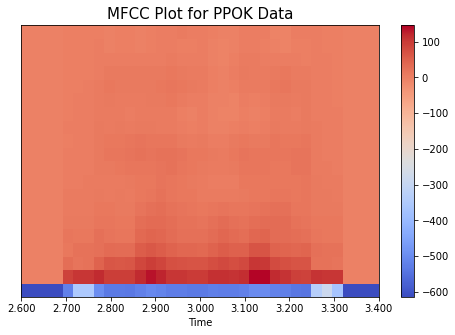

In [ ]:
mfccs = df.iloc[42]["mfcc"]
print(mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (8,5))
img = librosa.display.specshow(mfccs, sr = 22050, x_axis='time')
plt.colorbar(img)
plt.title("MFCC Plot for PPOK Data", fontsize = 15)
plt.xlim(2.6,3.4)
plt.show()

(20, 259)


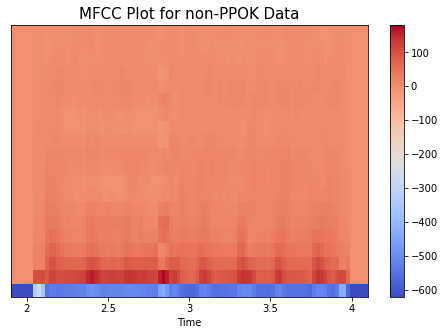

In [ ]:
mfccs = df.iloc[24]["mfcc"]
print(mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (8,5))
img = librosa.display.specshow(mfccs, sr = 22050, x_axis='time')
plt.colorbar(img)
plt.title("MFCC Plot for non-PPOK Data", fontsize = 15)
plt.xlim(1.9,4.1)
plt.show()

In [ ]:
'''
Matrix Similarity
'''
a = df.iloc[42]["mfcc"].flatten()
b = df.iloc[100]["mfcc"].flatten()

from scipy import spatial
result = 1 - spatial.distance.cosine(a, b)
result

0.9856603741645813

## From CSTFT

(12, 259)


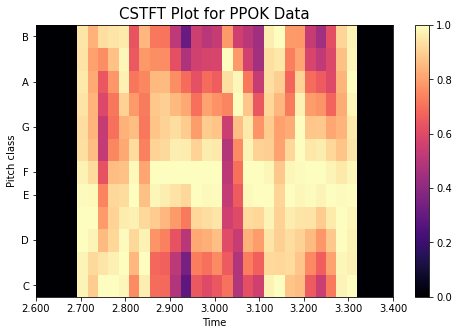

In [ ]:
chroma = df.iloc[42]["cstft"]
print(chroma.shape)

#Displaying  the Chroma:
plt.figure(figsize = (8,5))
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar(img)
plt.title("CSTFT Plot for PPOK Data", fontsize = 15)
plt.xlim(2.6,3.4)
plt.show()

(12, 259)


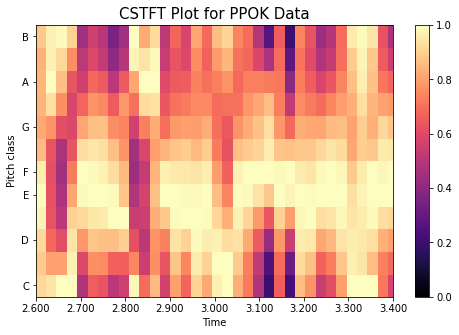

In [ ]:
chroma = df.iloc[24]["cstft"]
print(chroma.shape)

#Displaying  the Chroma:
plt.figure(figsize = (8,5))
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar(img)
plt.title("CSTFT Plot for PPOK Data", fontsize = 15)
plt.xlim(2.6,3.4)
plt.show()

In [ ]:
'''
Matrix Similarity
'''
a = df.iloc[24]["mfcc"].flatten()
b = df.iloc[42]["mfcc"].flatten()

from scipy import spatial
result = 1 - spatial.distance.cosine(a, b)
result

0.9870253205299377

## From MelSpectogram

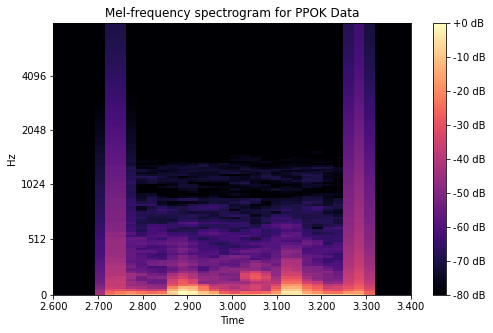

In [ ]:
mspec = df.iloc[42]["mspec"]

#Displaying  the MelSpectogram:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
S_dB = librosa.power_to_db(mspec, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram for PPOK Data')
plt.xlim(2.6,3.4)
plt.show()

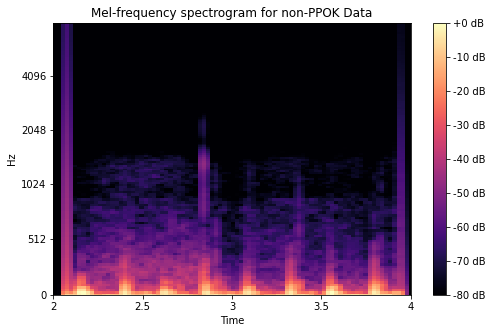

In [ ]:
mspec = df.iloc[24]["mspec"]

#Displaying  the MelSpectogram:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8,5))
S_dB = librosa.power_to_db(mspec, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram for non-PPOK Data')
plt.xlim(2,4)
plt.show()

In [ ]:
'''
Matrix Similarity
'''
a = df.iloc[24]["mfcc"].flatten()
b = df.iloc[42]["mfcc"].flatten()

from scipy import spatial
result = 1 - spatial.distance.cosine(a, b)
result

0.9870253205299377

## From Raw File

In [ ]:
df["index"] = [i for i in range(len(df))]

In [ ]:
df.iloc[42]

patient_id                                                  104
rec_index                                                   1b1
chest_loc                                                    Al
acq_mode                                                     sc
rec_equip                                              Litt3200
start                                                       0.0
end                                                      1.8771
crackles                                                      0
weezels                                                       0
file_name                                104_1b1_Al_sc_Litt3200
diag                                                       COPD
mfcc          [[-613.4402, -613.4402, -613.4402, -613.4402, ...
cstft         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
mspec         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
len_mfcc                                                     20
len_cstft                               

In [ ]:
df.iloc[23]

patient_id                                                  102
rec_index                                                   1b1
chest_loc                                                    Ar
acq_mode                                                     sc
rec_equip                                              Meditron
start                                                     0.264
end                                                       1.736
crackles                                                      0
weezels                                                       0
file_name                                102_1b1_Ar_sc_Meditron
diag                                                    Healthy
mfcc          [[-613.4402, -613.4402, -613.4402, -613.4402, ...
cstft         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
mspec         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
len_mfcc                                                     20
len_cstft                               

In [ ]:
df["diag"].unique()

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis'],
      dtype=object)

In [ ]:
df[df["diag"] == "Healthy"]["index"]

0      23
1      24
2      25
3      26
4      27
     ... 
4    3980
5    3981
6    3982
7    3983
8    3984
Name: index, Length: 176, dtype: int64

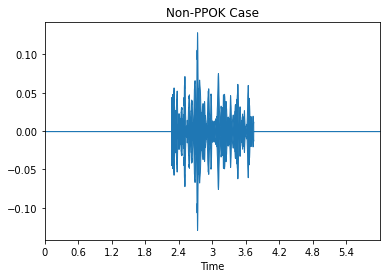

In [ ]:
librosa.display.waveplot(audio_arr[23], 
                         sr = 22050, 
                         max_points = 50000, 
                         x_axis ='time', offset=0.0, max_sr=1000)
plt.title("Non-PPOK Case")
plt.show()

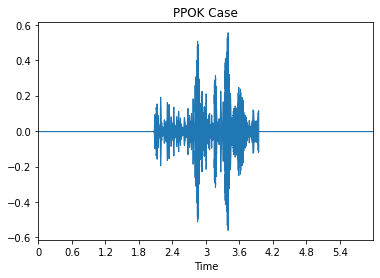

In [ ]:
librosa.display.waveplot(audio_arr[42], 
                         sr = 22050, 
                         max_points = 50000) 
                         #x_axis ='time', offset=0.0, max_sr=1000)
plt.title("PPOK Case")
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
librosa.display.waveplot(data1,sr=sample_rate1, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)

# MODELING

In [ ]:
df["binary_diag"] = df["diag"].apply(lambda row : "non-COPD" if row != "COPD" else row)

## LSTM using MFCC only

In [ ]:
#Feature
X = np.array(df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())
#X = tf.convert_to_tensor(np.array(final["data"].to_list()))
#X = [array for array in final["data"]]

#Target
y = np.array(df["binary_diag"].to_list())
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y)) #similar with get_dummies function in pandas
#y = labelencoder.fit_transform(y)

#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0],y_train.shape[1])
#y_train = y_train.reshape(y_train.shape[0],1, 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
#y_test = y_test.reshape(y_test.shape[0],1, 1)

ValueError: ignored

In [ ]:
print(f"Training data shape : {X_train.shape}")
print(f"Training label shape : {y_train.shape}")
print(f"Validation data shape : {X_test.shape}")
print(f"Validation label shape : {y_test.shape}")

Training data shape : (154, 40, 1)
Training label shape : (154, 4)
Validation data shape : (77, 40, 1)
Validation label shape : (77, 4)


In [ ]:
import keras 
from tensorflow.keras.layers import LSTM, Dense,Dropout

input_shape=(40,1)

model = keras.Sequential()
model.add(LSTM(256,input_shape=input_shape))
model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax')) #output 4 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [ ]:
import keras 
from tensorflow.keras.layers import LSTM, Dense,Dropout

input_shape=(40,1)

model = keras.Sequential()
model.add(LSTM(256,input_shape=input_shape))
model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(4, activation='softmax')) #output 4 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)               

In [ ]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size = 72, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
3/3 [==============================] - 4s 505ms/step - loss: 1.6053 - accuracy: 0.0974 - val_loss: 1.5396 - val_accuracy: 0.1039
Epoch 2/100
3/3 [==============================] - 1s 197ms/step - loss: 1.5295 - accuracy: 0.0974 - val_loss: 1.4708 - val_accuracy: 0.1039
Epoch 3/100
3/3 [==============================] - 1s 197ms/step - loss: 1.4616 - accuracy: 0.0974 - val_loss: 1.4144 - val_accuracy: 0.1039
Epoch 4/100
3/3 [==============================] - 1s 190ms/step - loss: 1.4059 - accuracy: 0.0974 - val_loss: 1.3710 - val_accuracy: 0.1039
Epoch 5/100
3/3 [==============================] - 1s 186ms/step - loss: 1.3616 - accuracy: 0.1234 - val_loss: 1.3374 - val_accuracy: 0.5325
Epoch 6/100
3/3 [==============================] - 1s 185ms/step - loss: 1.3276 - accuracy: 0.4935 - val_loss: 1.3114 - val_accuracy: 0.5325
Epoch 7/100
3/3 [==============================] - 1s 183ms/step - loss: 1.3022 - accuracy: 0.5390 - val_loss: 1.2908 - val_accuracy: 0.5325
Epoch 8/100
3

## CNN Using MFCC ONLY

In [ ]:
df["binary_diag"] = df["diag"].apply(lambda row : "non-COPD" if row != "COPD" else row)

### With Overall Imbalanced Data

In [ ]:
'''
60-40 Train Test Data [UNDERSAMPLE]
'''
temp_df = pd.concat((df[df["binary_diag"] != "COPD"][["mfcc" , "binary_diag"]] , df[df["binary_diag"] == "COPD"][["mfcc" , "binary_diag"]].sample(len(df[df["binary_diag"] != "COPD"]), random_state = 42)))
temp_df 

mfcc binary_diag
0   [[-613.4402, -613.4402, -613.4402, -613.4402, ...    non-COPD
1   [[-621.05994, -621.05994, -621.05994, -621.059...    non-COPD
2   [[-619.62665, -619.62665, -619.62665, -619.626...    non-COPD
3   [[-629.2678, -629.2678, -629.2678, -629.2678, ...    non-COPD
4   [[-655.7785, -655.7785, -655.7785, -655.7785, ...    non-COPD
..                                                ...         ...
0   [[-613.4402, -613.4402, -613.4402, -613.4402, ...        COPD
0   [[-613.4402, -613.4402, -613.4402, -613.4402, ...        COPD
0   [[-613.4402, -613.4402, -613.4402, -613.4402, ...        COPD
4   [[-655.7785, -655.7785, -655.7785, -655.7785, ...        COPD
15  [[-660.4171, -660.4171, -660.4171, -660.4171, ...        COPD

[1426 rows x 2 columns]

In [ ]:
#Feature
X = np.array(temp_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()} #inverse mapping
y = np.array(temp_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
'''
Test Proportion of Train and Test 
'''
print("Train :")
print(pd.Series(y_train).map(inv_diag_dict).value_counts()  / len(y_train) * 100)
print("\nTest: ")
print(pd.Series(y_test).map(inv_diag_dict).value_counts()  / len(y_test) * 100)

Train :
non-COPD    50.157068
COPD        49.842932
dtype: float64

Test: 
COPD        50.318471
non-COPD    49.681529
dtype: float64


In [ ]:
'''
CNN MODEL 
'''
from tensorflow import keras

mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.GlobalMaxPooling2D()(x)

hidden=keras.layers.Dropout(0.2)(x)
hidden=keras.layers.Dense(50,activation='relu')(x)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
mfcc_output=keras.layers.Dense(2,activation='softmax')(hidden)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
'''
Set Checkpoint for the best model
'''
from tensorflow.keras.callbacks import ModelCheckpoint
import time
filepath = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/MFCC_CNN_50-50.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_loss",verbose=1, save_best_only=True, mode="min")

callbacks = [checkpoint]

'''
Compile and Fitting Model 
'''
mfcc_model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
start = time.time()
mfcc_model = mfcc_model.fit(X_train, y_train, epochs=50, 
               validation_data = (X_test, y_test), 
               callbacks = callbacks)
print(f"Runtime {time.time()-start} seconds")

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.8388 - accuracy: 0.5026
Epoch 1: val_loss improved from inf to 0.69612, saving model to /content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/MFCC_CNN_50-50.epoch01-loss0.70.hdf5
30/30 [==============================] - 7s 135ms/step - loss: 0.8388 - accuracy: 0.5026 - val_loss: 0.6961 - val_accuracy: 0.5032
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.7166 - accuracy: 0.4859
Epoch 2: val_loss improved from 0.69612 to 0.69336, saving model to /content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/MFCC_CNN_50-50.epoch02-loss0.69.hdf5
30/30 [==============================] - 3s 117ms/step - loss: 0.7166 - accuracy: 0.4859 - val_loss: 0.6934 - val_accuracy: 0.4968
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.4942
Epoch 3: val_loss did not improve from 0.69336
30/30 [==============================] - 3s 116ms/s

## Binary Class DataSet

### Imbalanced Data Set

#### Training

##### Splitting Dataset

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.33, random_state = 42)

'''
CSTFT
'''
#Feature
cstft_X = np.array(df["cstft"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
cstft_y = np.array(df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
cstft_X_train, cstft_X_test, cstft_y_train, cstft_y_test = train_test_split(cstft_X, cstft_y, test_size = 0.33, random_state = 42)

'''
Chroma
'''
#Feature
chroma_X = np.array(df["mspec"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
chroma_y = np.array(df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
chroma_X_train, chroma_X_test, chroma_y_train, chroma_y_test = train_test_split(chroma_X, chroma_y, test_size = 0.33, random_state = 42)


In [ ]:
'''
Test Proportion of Train and Test 
'''
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()}
print("MFCC")
print("Train :")
print(pd.Series(mfcc_y_train).map(inv_diag_dict).value_counts()  / len(mfcc_y_train) * 100)
print("\nTest: ")
print(pd.Series(mfcc_y_test).map(inv_diag_dict).value_counts()  / len(mfcc_y_test) * 100)
print()
print("CSTFT")
print("Train :")
print(pd.Series(cstft_y_train).map(inv_diag_dict).value_counts()  / len(cstft_y_train) * 100)
print("\nTest: ")
print(pd.Series(cstft_y_test).map(inv_diag_dict).value_counts()  / len(cstft_y_test) * 100)
print()
print("CHROMA")
print("Train :")
print(pd.Series(chroma_y_train).map(inv_diag_dict).value_counts()  / len(chroma_y_train) * 100)
print("\nTest: ")
print(pd.Series(chroma_y_test).map(inv_diag_dict).value_counts()  / len(chroma_y_test) * 100)
print()

MFCC
Train :
COPD        83.142177
non-COPD    16.857823
dtype: float64

Test: 
COPD        83.618797
non-COPD    16.381203
dtype: float64

CSTFT
Train :
COPD        83.142177
non-COPD    16.857823
dtype: float64

Test: 
COPD        83.618797
non-COPD    16.381203
dtype: float64

CHROMA
Train :
COPD        83.142177
non-COPD    16.857823
dtype: float64

Test: 
COPD        83.618797
non-COPD    16.381203
dtype: float64



In [ ]:
print("MFCC")
print(f"Training data shape : {mfcc_X_train.shape}")
print(f"Training label shape : {mfcc_y_train.shape}")
print(f"Validation data shape : {mfcc_X_test.shape}")
print(f"Validation label shape : {mfcc_y_test.shape}")
print()
print("CSTFT")
print(f"Training data shape : {cstft_X_train.shape}")
print(f"Training label shape : {cstft_y_train.shape}")
print(f"Validation data shape : {cstft_X_test.shape}")
print(f"Validation label shape : {cstft_y_test.shape}")
print()
print("CHROMA")
print(f"Training data shape : {chroma_X_train.shape}")
print(f"Training label shape : {chroma_y_train.shape}")
print(f"Validation data shape : {chroma_X_test.shape}")
print(f"Validation label shape : {chroma_y_test.shape}")
print()

MFCC
Training data shape : (4621, 20, 259)
Training label shape : (4621,)
Validation data shape : (2277, 20, 259)
Validation label shape : (2277,)

CSTFT
Training data shape : (4621, 12, 259)
Training label shape : (4621,)
Validation data shape : (2277, 12, 259)
Validation label shape : (2277,)

CHROMA
Training data shape : (4621, 128, 259)
Training label shape : (4621,)
Validation data shape : (2277, 128, 259)
Validation label shape : (2277,)



##### Model 

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(4,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
np.logical_and( (mfcc_y_train==cstft_y_train).all(), (cstft_y_train==chroma_y_train).all() )

True

In [ ]:
np.logical_and( (mfcc_y_test==cstft_y_test).all(), (cstft_y_test==chroma_y_test).all() )

True

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

history=net.fit(
    {"mfcc":mfcc_X_train,"croma":cstft_X_train,"mspec":chroma_X_train},
    mfcc_y_train,
    validation_data=({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test},mfcc_y_test),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

#### Model Evaluation

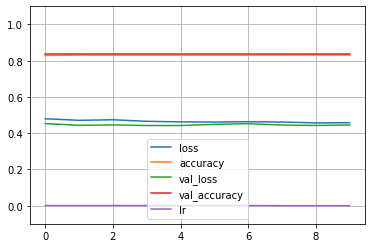

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
net.save("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/3type_binary_imbalanced.hdf5")

In [ ]:
'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_imbalanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test})
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = mfcc_y_test

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

72/72 [==============================] - 8s 105ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       373
        COPD       0.84      1.00      0.91      1904

    accuracy                           0.84      2277
   macro avg       0.42      0.50      0.46      2277
weighted avg       0.70      0.84      0.76      2277



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


41/41 [==============================] - 4s 84ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       373
        COPD       0.71      1.00      0.83       932

    accuracy                           0.71      1305
   macro avg       0.36      0.50      0.42      1305
weighted avg       0.51      0.71      0.60      1305



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


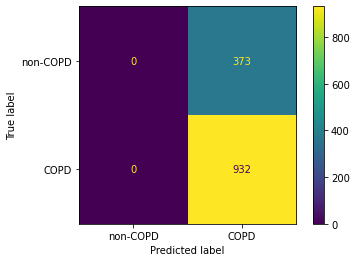

In [ ]:
'''
70 (COPD) - 30 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) * 2.5),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_imbalanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

35/35 [==============================] - 4s 110ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       373
        COPD       0.67      1.00      0.80       746

    accuracy                           0.67      1119
   macro avg       0.33      0.50      0.40      1119
weighted avg       0.44      0.67      0.53      1119



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


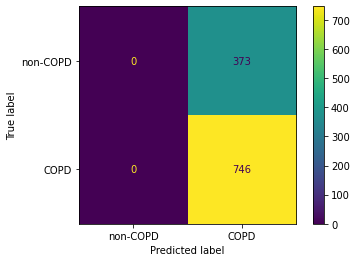

In [ ]:
'''
60 (COPD) - 40 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) * 2),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_imbalanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

24/24 [==============================] - 2s 65ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       373
        COPD       0.50      1.00      0.67       373

    accuracy                           0.50       746
   macro avg       0.25      0.50      0.33       746
weighted avg       0.25      0.50      0.33       746



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


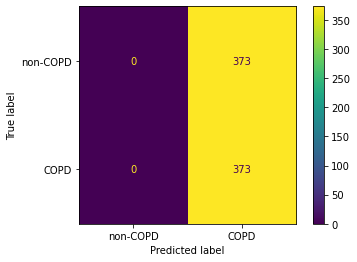

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_imbalanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

precision dari COPD : seberapa bagus model menebak dia COPD (TP / (TP+FP)) \
recall :  \
f1_score : sensitivity , TP /(TP+FN) 

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"].sample(round(len(eq_df_1) * 2),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts() / len(eq_df) * 100

COPD        66.666667
non-COPD    33.333333
Name: binary_diag, dtype: float64

### Balanced Data Set

#### Training

##### Splitting Data 

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"].sample(len(eq_df_1),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts()

non-COPD    713
COPD        713
Name: binary_diag, dtype: int64

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(eq_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.2, random_state = 42)

'''
CSTFT
'''
#Feature
cstft_X = np.array(eq_df["cstft"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
cstft_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
cstft_X_train, cstft_X_test, cstft_y_train, cstft_y_test = train_test_split(cstft_X, cstft_y, test_size = 0.2, random_state = 42)

'''
Mel Spectogram
'''
#Feature
chroma_X = np.array(eq_df["mspec"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
chroma_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
chroma_X_train, chroma_X_test, chroma_y_train, chroma_y_test = train_test_split(chroma_X, chroma_y, test_size = 0.2, random_state = 42)


In [ ]:
'''
Test Proportion of Train and Test 
'''
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()}
print("MFCC")
print("Train :")
print(pd.Series(mfcc_y_train).map(inv_diag_dict).value_counts()  / len(mfcc_y_train) * 100)
print("\nTest: ")
print(pd.Series(mfcc_y_test).map(inv_diag_dict).value_counts()  / len(mfcc_y_test) * 100)
print()
print("CSTFT")
print("Train :")
print(pd.Series(cstft_y_train).map(inv_diag_dict).value_counts()  / len(cstft_y_train) * 100)
print("\nTest: ")
print(pd.Series(cstft_y_test).map(inv_diag_dict).value_counts()  / len(cstft_y_test) * 100)
print()
print("CHROMA")
print("Train :")
print(pd.Series(chroma_y_train).map(inv_diag_dict).value_counts()  / len(chroma_y_train) * 100)
print("\nTest: ")
print(pd.Series(chroma_y_test).map(inv_diag_dict).value_counts()  / len(chroma_y_test) * 100)
print()

MFCC
Train :
non-COPD    50.614035
COPD        49.385965
dtype: float64

Test: 
COPD        52.447552
non-COPD    47.552448
dtype: float64

CSTFT
Train :
non-COPD    50.614035
COPD        49.385965
dtype: float64

Test: 
COPD        52.447552
non-COPD    47.552448
dtype: float64

CHROMA
Train :
non-COPD    50.614035
COPD        49.385965
dtype: float64

Test: 
COPD        52.447552
non-COPD    47.552448
dtype: float64



In [ ]:
print("MFCC")
print(f"Training data shape : {mfcc_X_train.shape}")
print(f"Training label shape : {mfcc_y_train.shape}")
print(f"Validation data shape : {mfcc_X_test.shape}")
print(f"Validation label shape : {mfcc_y_test.shape}")
print()
print("CSTFT")
print(f"Training data shape : {cstft_X_train.shape}")
print(f"Training label shape : {cstft_y_train.shape}")
print(f"Validation data shape : {cstft_X_test.shape}")
print(f"Validation label shape : {cstft_y_test.shape}")
print()
print("CHROMA")
print(f"Training data shape : {chroma_X_train.shape}")
print(f"Training label shape : {chroma_y_train.shape}")
print(f"Validation data shape : {chroma_X_test.shape}")
print(f"Validation label shape : {chroma_y_test.shape}")
print()

MFCC
Training data shape : (1140, 20, 259)
Training label shape : (1140,)
Validation data shape : (286, 20, 259)
Validation label shape : (286,)

CSTFT
Training data shape : (1140, 12, 259)
Training label shape : (1140,)
Validation data shape : (286, 12, 259)
Validation label shape : (286,)

CHROMA
Training data shape : (1140, 128, 259)
Training label shape : (1140,)
Validation data shape : (286, 128, 259)
Validation label shape : (286,)



##### Model 

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(2,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

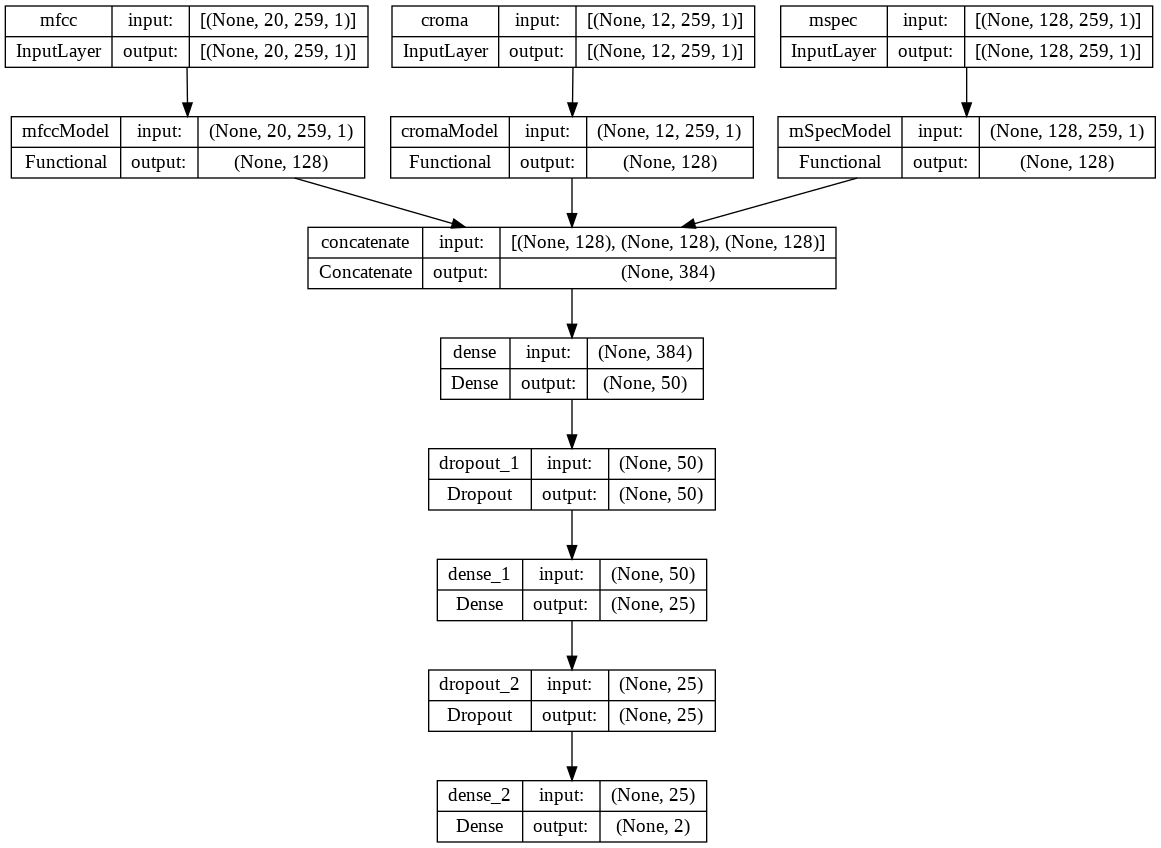

In [ ]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
np.logical_and( (mfcc_y_train==cstft_y_train).all(), (cstft_y_train==chroma_y_train).all() )

True

In [ ]:
np.logical_and( (mfcc_y_test==cstft_y_test).all(), (cstft_y_test==chroma_y_test).all() )

True

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]
#harusnya chroma --> mSpec
history=net.fit(
    {"mfcc":mfcc_X_train,"croma":cstft_X_train,"mspec":chroma_X_train},
    mfcc_y_train,
    validation_data=({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test},mfcc_y_test),
    epochs=50,verbose=0,
    callbacks=my_callbacks
)

In [ ]:
net.save("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/3type_binary_balanced_7nov.hdf5")

#### Model Evaluation

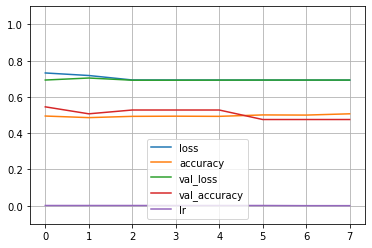

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
'''
Load Model and Predict the Test Data on Training Table 
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test})
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = mfcc_y_test

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

9/9 [==============================] - 2s 120ms/step
              precision    recall  f1-score   support

    non-COPD       0.48      1.00      0.64       136
        COPD       0.00      0.00      0.00       150

    accuracy                           0.48       286
   macro avg       0.24      0.50      0.32       286
weighted avg       0.23      0.48      0.31       286



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
'''
70 (COPD) - 30 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) * 2.5),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

ValueError: ignored

9/9 [==============================] - 2s 165ms/step
              precision    recall  f1-score   support

    non-COPD       0.50      1.00      0.67       136
        COPD       0.00      0.00      0.00       136

    accuracy                           0.50       272
   macro avg       0.25      0.50      0.33       272
weighted avg       0.25      0.50      0.33       272



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


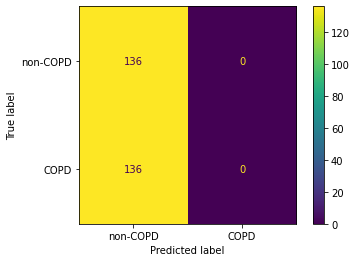

In [ ]:
'''
60 (COPD) - 40 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) ),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced_7nov.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

### in between Balanced Data Set 70 - 30 training process

#### Training

##### Splitting Data 

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"].sample(round(len(eq_df_1)*2.5),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts() / len(eq_df)

COPD        0.714286
non-COPD    0.285714
Name: binary_diag, dtype: float64

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(eq_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.33, random_state = 42)

'''
CSTFT
'''
#Feature
cstft_X = np.array(eq_df["cstft"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
cstft_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
cstft_X_train, cstft_X_test, cstft_y_train, cstft_y_test = train_test_split(cstft_X, cstft_y, test_size = 0.33, random_state = 42)

'''
Chroma
'''
#Feature
chroma_X = np.array(eq_df["mspec"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
chroma_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
chroma_X_train, chroma_X_test, chroma_y_train, chroma_y_test = train_test_split(chroma_X, chroma_y, test_size = 0.33, random_state = 42)


In [ ]:
'''
Test Proportion of Train and Test 
'''
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()}
print("MFCC")
print("Train :")
print(pd.Series(mfcc_y_train).map(inv_diag_dict).value_counts()  / len(mfcc_y_train) * 100)
print("\nTest: ")
print(pd.Series(mfcc_y_test).map(inv_diag_dict).value_counts()  / len(mfcc_y_test) * 100)
print()
print("CSTFT")
print("Train :")
print(pd.Series(cstft_y_train).map(inv_diag_dict).value_counts()  / len(cstft_y_train) * 100)
print("\nTest: ")
print(pd.Series(cstft_y_test).map(inv_diag_dict).value_counts()  / len(cstft_y_test) * 100)
print()
print("CHROMA")
print("Train :")
print(pd.Series(chroma_y_train).map(inv_diag_dict).value_counts()  / len(chroma_y_train) * 100)
print("\nTest: ")
print(pd.Series(chroma_y_test).map(inv_diag_dict).value_counts()  / len(chroma_y_test) * 100)
print()

MFCC
Train :
COPD        72.343576
non-COPD    27.656424
dtype: float64

Test: 
COPD        69.571751
non-COPD    30.428249
dtype: float64

CSTFT
Train :
COPD        72.343576
non-COPD    27.656424
dtype: float64

Test: 
COPD        69.571751
non-COPD    30.428249
dtype: float64

CHROMA
Train :
COPD        72.343576
non-COPD    27.656424
dtype: float64

Test: 
COPD        69.571751
non-COPD    30.428249
dtype: float64



In [ ]:
print("MFCC")
print(f"Training data shape : {mfcc_X_train.shape}")
print(f"Training label shape : {mfcc_y_train.shape}")
print(f"Validation data shape : {mfcc_X_test.shape}")
print(f"Validation label shape : {mfcc_y_test.shape}")
print()
print("CSTFT")
print(f"Training data shape : {cstft_X_train.shape}")
print(f"Training label shape : {cstft_y_train.shape}")
print(f"Validation data shape : {cstft_X_test.shape}")
print(f"Validation label shape : {cstft_y_test.shape}")
print()
print("CHROMA")
print(f"Training data shape : {chroma_X_train.shape}")
print(f"Training label shape : {chroma_y_train.shape}")
print(f"Validation data shape : {chroma_X_test.shape}")
print(f"Validation label shape : {chroma_y_test.shape}")
print()

MFCC
Training data shape : (2701, 20, 259)
Training label shape : (2701,)
Validation data shape : (1331, 20, 259)
Validation label shape : (1331,)

CSTFT
Training data shape : (2701, 12, 259)
Training label shape : (2701,)
Validation data shape : (1331, 12, 259)
Validation label shape : (1331,)

CHROMA
Training data shape : (2701, 128, 259)
Training label shape : (2701,)
Validation data shape : (1331, 128, 259)
Validation label shape : (1331,)



##### Model 

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(2,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
np.logical_and( (mfcc_y_train==cstft_y_train).all(), (cstft_y_train==chroma_y_train).all() )

True

In [ ]:
np.logical_and( (mfcc_y_test==cstft_y_test).all(), (cstft_y_test==chroma_y_test).all() )

True

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

history=net.fit(
    {"mfcc":mfcc_X_train,"croma":cstft_X_train,"mspec":chroma_X_train},
    mfcc_y_train,
    validation_data=({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test},mfcc_y_test),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

In [ ]:
net.save("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/3type_binary_70-30.hdf5")

#### Model Evaluation

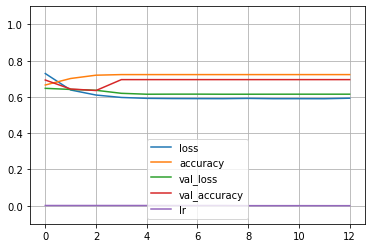

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

42/42 [==============================] - 11s 241ms/step
              precision    recall  f1-score   support

    non-COPD       0.00      0.00      0.00       405
        COPD       0.70      1.00      0.82       926

    accuracy                           0.70      1331
   macro avg       0.35      0.50      0.41      1331
weighted avg       0.48      0.70      0.57      1331



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


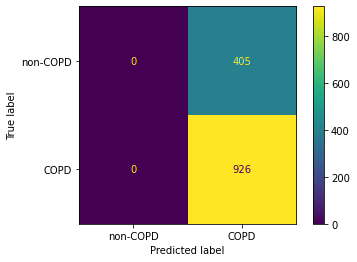

In [ ]:
'''
70 (COPD) - 30 (non-COPD)
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_70-30.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test})
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = mfcc_y_test

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))


'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

32/32 [==============================] - 4s 108ms/step
              precision    recall  f1-score   support

    non-COPD       0.52      0.25      0.34       405
        COPD       0.63      0.84      0.72       608

    accuracy                           0.61      1013
   macro avg       0.57      0.55      0.53      1013
weighted avg       0.58      0.61      0.57      1013



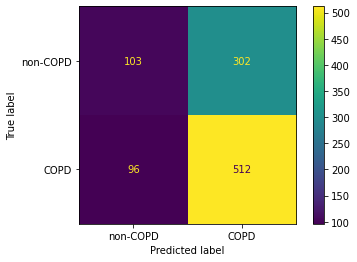

In [ ]:
'''
60 (COPD) - 40 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0) * 1.5),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

26/26 [==============================] - 5s 166ms/step
              precision    recall  f1-score   support

    non-COPD       0.64      0.25      0.36       405
        COPD       0.53      0.86      0.66       405

    accuracy                           0.56       810
   macro avg       0.59      0.56      0.51       810
weighted avg       0.59      0.56      0.51       810



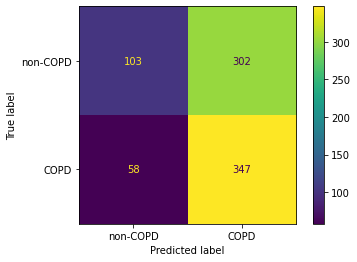

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

### in between Balanced Data Set 60 - 40 training process

#### Training

##### Splitting Data 

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"].sample(round(len(eq_df_1)*1.5),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts() / len(eq_df)

COPD        0.6
non-COPD    0.4
Name: binary_diag, dtype: float64

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(eq_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.33, random_state = 42)

'''
CSTFT
'''
#Feature
cstft_X = np.array(eq_df["cstft"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
cstft_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
cstft_X_train, cstft_X_test, cstft_y_train, cstft_y_test = train_test_split(cstft_X, cstft_y, test_size = 0.33, random_state = 42)

'''
Chroma
'''
#Feature
chroma_X = np.array(eq_df["mspec"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
chroma_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
chroma_X_train, chroma_X_test, chroma_y_train, chroma_y_test = train_test_split(chroma_X, chroma_y, test_size = 0.33, random_state = 42)


In [ ]:
'''
Test Proportion of Train and Test 
'''
inv_diag_dict = {v: k for k, v in binary_diag_dict.items()}
print("MFCC")
print("Train :")
print(pd.Series(mfcc_y_train).map(inv_diag_dict).value_counts()  / len(mfcc_y_train) * 100)
print("\nTest: ")
print(pd.Series(mfcc_y_test).map(inv_diag_dict).value_counts()  / len(mfcc_y_test) * 100)
print()
print("CSTFT")
print("Train :")
print(pd.Series(cstft_y_train).map(inv_diag_dict).value_counts()  / len(cstft_y_train) * 100)
print("\nTest: ")
print(pd.Series(cstft_y_test).map(inv_diag_dict).value_counts()  / len(cstft_y_test) * 100)
print()
print("CHROMA")
print("Train :")
print(pd.Series(chroma_y_train).map(inv_diag_dict).value_counts()  / len(chroma_y_train) * 100)
print("\nTest: ")
print(pd.Series(chroma_y_test).map(inv_diag_dict).value_counts()  / len(chroma_y_test) * 100)
print()

MFCC
Train :
COPD        60.653188
non-COPD    39.346812
dtype: float64

Test: 
COPD        58.675079
non-COPD    41.324921
dtype: float64

CSTFT
Train :
COPD        60.653188
non-COPD    39.346812
dtype: float64

Test: 
COPD        58.675079
non-COPD    41.324921
dtype: float64

CHROMA
Train :
COPD        60.653188
non-COPD    39.346812
dtype: float64

Test: 
COPD        58.675079
non-COPD    41.324921
dtype: float64



In [ ]:
print("MFCC")
print(f"Training data shape : {mfcc_X_train.shape}")
print(f"Training label shape : {mfcc_y_train.shape}")
print(f"Validation data shape : {mfcc_X_test.shape}")
print(f"Validation label shape : {mfcc_y_test.shape}")
print()
print("CSTFT")
print(f"Training data shape : {cstft_X_train.shape}")
print(f"Training label shape : {cstft_y_train.shape}")
print(f"Validation data shape : {cstft_X_test.shape}")
print(f"Validation label shape : {cstft_y_test.shape}")
print()
print("CHROMA")
print(f"Training data shape : {chroma_X_train.shape}")
print(f"Training label shape : {chroma_y_train.shape}")
print(f"Validation data shape : {chroma_X_test.shape}")
print(f"Validation label shape : {chroma_y_test.shape}")
print()

MFCC
Training data shape : (1929, 20, 259)
Training label shape : (1929,)
Validation data shape : (951, 20, 259)
Validation label shape : (951,)

CSTFT
Training data shape : (1929, 12, 259)
Training label shape : (1929,)
Validation data shape : (951, 12, 259)
Validation label shape : (951,)

CHROMA
Training data shape : (1929, 128, 259)
Training label shape : (1929,)
Validation data shape : (951, 128, 259)
Validation label shape : (951,)



##### Model 

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 87, 32)        832       
                                                                 
 batch_normalization_11 (Bat  (None, 20, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_15 (Bat  (None, 12, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_18 (Bat  (None, 64, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(2,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
np.logical_and( (mfcc_y_train==cstft_y_train).all(), (cstft_y_train==chroma_y_train).all() )

True

In [ ]:
np.logical_and( (mfcc_y_test==cstft_y_test).all(), (cstft_y_test==chroma_y_test).all() )

True

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

history=net.fit(
    {"mfcc":mfcc_X_train,"croma":cstft_X_train,"mspec":chroma_X_train},
    mfcc_y_train,
    validation_data=({"mfcc":mfcc_X_test,"croma":cstft_X_test,"mspec":chroma_X_test},mfcc_y_test),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

In [ ]:
net.save("/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/3type_binary_60-40.hdf5")

#### Model Evaluation

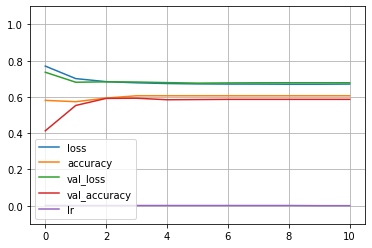

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

26/26 [==============================] - 5s 178ms/step
              precision    recall  f1-score   support

    non-COPD       0.45      0.29      0.35       248
        COPD       0.73      0.84      0.78       558

    accuracy                           0.67       806
   macro avg       0.59      0.57      0.57       806
weighted avg       0.64      0.67      0.65       806



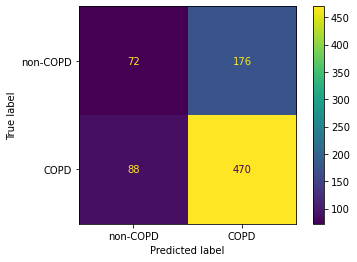

In [ ]:
'''
70 (COPD) - 30 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0]  #non-COPD
eq_y_0 = eq_y_0.sample(round(len(eq_y_0) * 0.63))
eq_y_1 = eq_y[eq_y == 1] #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

30/30 [==============================] - 5s 164ms/step
              precision    recall  f1-score   support

    non-COPD       0.54      0.27      0.36       393
        COPD       0.62      0.84      0.71       558

    accuracy                           0.60       951
   macro avg       0.58      0.55      0.54       951
weighted avg       0.59      0.60      0.57       951



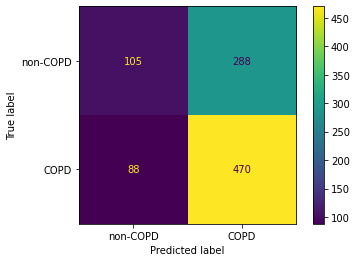

In [ ]:
'''
60 (COPD) - 40 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1]#.sample(round(len(eq_y_0) * 2),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

25/25 [==============================] - 4s 108ms/step
              precision    recall  f1-score   support

    non-COPD       0.66      0.27      0.38       393
        COPD       0.54      0.86      0.66       393

    accuracy                           0.56       786
   macro avg       0.60      0.56      0.52       786
weighted avg       0.60      0.56      0.52       786



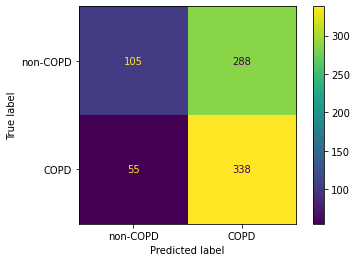

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc, eq_cstft, eq_chroma = mfcc_X_test[eq_y.index], cstft_X_test[eq_y.index], chroma_X_test[eq_y.index]

'''
Load Model and Predict the Test Data on Training Table on Imbalanced Data
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "3type_binary_balanced.hdf5"

model = keras.models.load_model(directory+best_model_file)

y_pred_weights = model.predict({"mfcc": eq_mfcc,"croma":eq_cstft,"mspec": eq_chroma}) #chroma harusny amspec
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = eq_y

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

'''
Confusion matrix
'''
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["non-COPD", "COPD"])
disp.plot()

# Other Model Test

In [ ]:
'''
Load Model and Predict the Test Data on Training Table 
'''
#Disable warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

directory = "/content/drive/MyDrive/Tugas Akhir/DATA + DESCRIPTION/Sound Database/MODELS/"
best_model_file = "binary_classification_all.epoch45-loss0.69.hdf5"

model = keras.models.load_model(directory+best_model_file)

In [ ]:
eq_df_1 = df[df["binary_diag"] == "non-COPD"]
eq_df_2 = df[df["binary_diag"] == "COPD"]#.sample(len(eq_df_1),random_state = 42)
eq_df = pd.concat((eq_df_1, eq_df_2))
eq_df["binary_diag"].value_counts()

COPD        3486
non-COPD     713
Name: binary_diag, dtype: int64

In [ ]:
'''
MFCC
'''
#Feature
mfcc_X = np.array(eq_df["mfcc"].apply(lambda row : tf.convert_to_tensor(np.array(row), dtype=float)).to_list())

#Target
binary_diag_dict = {'non-COPD': 0, 'COPD': 1} #mapping dictionary
mfcc_y = np.array(eq_df["binary_diag"].map(binary_diag_dict).to_list())

#Train-Test Split, use stratify to handle imbalanced data on the dataset
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size = 0.2, random_state = 42)

In [ ]:
'''
50 (COPD) - 50 (non-COPD)
'''
eq_y = pd.Series(mfcc_y_test)
eq_y_0 = eq_y[eq_y == 0] #non-COPD
eq_y_1 = eq_y[eq_y == 1].sample(round(len(eq_y_0)*1.5),random_state = 42) #COPD
eq_y = pd.concat((eq_y_0, eq_y_1)).sort_index()
eq_mfcc = mfcc_X_test[eq_y.index]

In [ ]:
eq_y.value_counts() / len(eq_y)

1    0.600484
0    0.399516
dtype: float64

In [ ]:
y_pred_weights = model.predict(mfcc_X_test)
y_pred_label = np.argmax(y_pred_weights, axis=-1)    
y_true = mfcc_y_test

target_names = ['non-COPD', 'COPD']
print(classification_report(y_true, y_pred_label, target_names=target_names))

27/27 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

    non-COPD       0.21      0.79      0.33       165
        COPD       0.84      0.26      0.40       675

    accuracy                           0.37       840
   macro avg       0.52      0.53      0.36       840
weighted avg       0.71      0.37      0.39       840

